# Modeling

In our first model before I go into feature selection, I'll quickly run a basic model. Since CRISP-DM is an iterative process, I'll start with this and then circle back as many times as necessary to get the results I'm looking for. I have split the data into 75% train and 25% test data for this model analysis.

In [1]:
#first import all the necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
%matplotlib inline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
#opening csv file as dataframe
df = pd.read_csv('house_sale_cleaned.csv')
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year,waterfront
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,...,1955,0.0,98178,47.5112,-122.257,1340,5650,10,2014,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,12,2014,0.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,...,1933,0.0,98028,47.7379,-122.233,2720,8062,2,2015,0.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,...,1965,0.0,98136,47.5208,-122.393,1360,5000,12,2014,0.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,...,1987,0.0,98074,47.6168,-122.045,1800,7503,2,2015,0.0


In [3]:
df.shape

(21247, 21)

In [4]:
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'month', 'year', 'waterfront'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21247 entries, 0 to 21246
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21247 non-null  int64  
 1   price          21247 non-null  float64
 2   bedrooms       21247 non-null  int64  
 3   bathrooms      21247 non-null  float64
 4   sqft_living    21247 non-null  int64  
 5   sqft_lot       21247 non-null  int64  
 6   floors         21247 non-null  float64
 7   view           21247 non-null  float64
 8   condition      21247 non-null  int64  
 9   grade          21247 non-null  int64  
 10  sqft_basement  21247 non-null  float64
 11  yr_built       21247 non-null  int64  
 12  yr_renovated   21247 non-null  float64
 13  zipcode        21247 non-null  int64  
 14  lat            21247 non-null  float64
 15  long           21247 non-null  float64
 16  sqft_living15  21247 non-null  int64  
 17  sqft_lot15     21247 non-null  int64  
 18  month 

### Tools/Functions 


Since this is an iterative process I will initialy create a function for each iteration of code that I will need through out the coding.

In [6]:
def regress_plots(columns, model):
    
    '''
    Takes in a list of column names found in the DataFrame that is used in a statsmodel linear regression and 
    plots 4 Regression Plots for each variable to show residuals per variable.
    
    Parameters
    ----------
    columns:    (list) - List of column names belonging to DataFrame used in statsmodel linear regression model
    model:    (sm model) - a statsmodel linear regression model that contains the list of columns.
    
    Returns
    ----------
    A regress plot of all residuals for each column
    '''    
    for column in columns:
        fig = plt.figure(figsize=(15,8))
        fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
        plt.show()

In [7]:
def qqplot(model):
    '''
    Takes in a StatsModel linear regression and plots a residual QQ Plot to check for normality and homoscedasticity.
    Parameters
    -------
    model:    (sm model) - a StatsModel fitted linear regression model
    Outputs
    --------
    A QQ Plot of the residuals to check for normality
    
    '''
    residuals = model.resid
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

In [8]:
def log_transform(df, column):
    
    '''
    Takes in a column name from the main data dataframe and creates 2 subplots showing histograms to compare 
    the differences between the original data and the log of that data.
    
    Parameters
    -----------
    df:    (DataFrame) - A DataFrame containing the columns being investigated
    column:    (str) - the column name of the data to be transformed
    
    Outputs
    ------------
    2 side-by-side subplots showing histograms of the original data and the log of that data
    '''
    
    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(1, 2, 1)
    df[column].plot.hist(ax=ax1, edgecolor='black')
    ax1.set_title(f'{column}')
    
    column_log = np.log1p(abs(df[column]))
    ax2 = plt.subplot(1, 2, 2)
    plt.hist(column_log, edgecolor='black')
    ax2.set_title(f'Log of {column}')

In [9]:
def sk_linear_regression(df, predictors, outcome, log=False, 
                         random_seed=1066):
    
    '''
    Creates a linear regression model in Sci Kit Learn using a dataframe and defined predictors/outcomes 
    using a random split of train/test data. Analyzes the model and provides an R2 score, RMSE and MAE of the test
    and training data for comparison.
    Parameters
    -----------
    df:    (DataFrame) - a DataFrame containing test data for the regression
    predictors:    (list) - a list of columns of variables to be included in 
    outcome:    (str) - the string name of y variable column for the linear regression
    random_seed:    (int) - the value of the random seed used for the train/test split. Default = 1066
    log:    (bool) - Boolean determining if the outcome should be log transformed
    Returns
    -----------
    lr:    (LinearRegression()) - A Sci-Kit Learn linear regression model
    Metrics:   Prints a report of the Root Mean Squared Error, R2 Score and Absolute Mean Error for both test and train data
    Plot:    a plot of the residuals of the test and the train data for comparison next to a histogram of both data sets
    '''
    
    lr = LinearRegression()
    
    X = df[predictors]
    y = df[outcome]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        random_state=random_seed)
    
    if log == False:            
            y_train_final = y_train
            y_test_final = y_test
            
            lr.fit(X_train, y_train_final)

            y_train_pred = lr.predict(X_train)
            y_test_pred = lr.predict(X_test)
            
            y_train_pred_final = y_train_pred
            y_test_pred_final = y_test_pred
        
    else:
        y_train_final = np.log(y_train)
        y_test_final = np.log(y_test)

        lr.fit(X_train, y_train_final)

        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)

        y_train_pred_final = np.exp(y_train_pred)
        y_test_pred_final = np.exp(y_test_pred)

      
    print("Training Scores:")
    print(f"R2: {r2_score(y_train_final, y_train_pred)}")

    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, y_train_pred_final))}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_final)}")
    print("---")
    print("Testing Scores:")
    print(f"R2: {r2_score(y_test_final, y_test_pred)}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_test_pred_final))}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_final)}")
            
    residuals_train = np.array(y_train_final) - np.array(y_train_pred)
    residuals_test = np.array(y_test_final) - np.array(y_test_pred)
    
    plt.figure(figsize=(15,5))
    
    ax1 = plt.subplot(1,2,1)
    
    plt.scatter(y_train_pred, residuals_train, color='yellow', alpha=.75)
    plt.scatter(y_test_pred, residuals_test, color='b', alpha=.75)

    plt.axhline(y=0, color='black')

    ax1.set_title('Residuals for Linear Regression Model')
    ax1.set_ylabel('Residuals')
    ax1.set_xlabel('Predicted Values')
    
    ax2 = plt.subplot(1,2,2)
    
    plt.hist(residuals_train, bins='auto', alpha=.75, color='yellow', edgecolor='y', label='Train')
    plt.hist(residuals_test, bins='auto', color='b', alpha=.75, edgecolor='y', label='Test')
    
    ax2.set_title('Histogram of Residuals')
    ax2.legend()
    
    plt.show()

    return lr

In [10]:
def sm_linear_regression(df, predictors, outcome, log = False, random_seed = 1066):

    '''
    Creates a linear regression model in StatsModels using a dataframe and defined predictors/outcomes 
    using a random split of train/test data. Returns a model ready for summary.
    Parameters
    -----------
    df:    (DataFrame) - a DataFrame containing test data for the regression
    predictors:    (list) - a list of columns of variables to be included in 
    outcome:    (str) - the string name of y variable column for the linear regression
    random_seed:    (int) - the value of the random seed used for the train/test split. Default = 1066
    -----------
    model:    (OLS) - A StatsModel linear regression model with a constant added
    '''
    
    X = df[predictors]
    y = df[outcome]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                        random_state=random_seed)
    
    if log == True:
        y_train = np.log(y_train)
    else:
        pass

    predictors_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, predictors_int).fit()
    
    return model


## Model #1: Base line 'Bad' Model

To begin I will establish a baseline with a model using both SKLearn and StatsModels. I will initially divide my data into 'continuous', 'categorical' and 'outcome' data. For the purpose of this model, categorical and continuous variables will both be treated as continuous except for the zipcode which I will deal with at the end for locational data model.

In [11]:
continuous = ['sqft_living','sqft_lot','yr_built','yr_renovated',
              'lat','long','sqft_living15','sqft_lot15','sqft_basement']
categorical = ['bedrooms', 'bathrooms', 'view', 'floors','waterfront',
               'condition','grade','month']
removed = ['id', 'year', 'zipcode']
outcome = ['price']

In [12]:
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'month', 'year', 'waterfront'],
      dtype='object')


I will use my sk_linear_regression function to produce my first model. It will also create a scatter plot of the model's residuals as well as a histogram of the test and train residuals for comparison.

Training Scores:
R2: 0.7137928505994281
Root Mean Squared Error: 145789.58294047008
Mean Absolute Error: 103620.39775013318
---
Testing Scores:
R2: 0.7054810661943268
Root Mean Squared Error: 153704.00225618394
Mean Absolute Error: 105286.70041933519


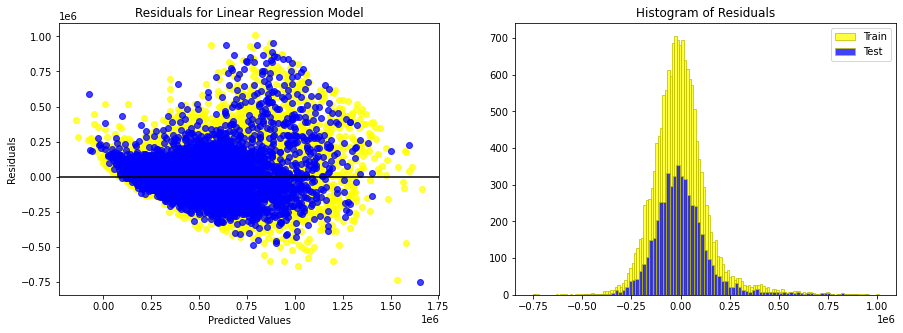

LinearRegression()

In [13]:
sk_linear_regression(df, continuous+categorical, outcome)

### Analysis

Taking note on the R2 score of 0.71379 for training data and 0.7054 for the test data our model can account for about 71.38% of the testing data's variance. Practicly speaking our outcome data would have an error of around $153,704, which is a lot.
Moreover the test error has a higher value than the training error indicating an overfit model. This could use some work done on it. Also from the residuals plots, notice a strong heteroscedasticity creating a funnel like pattern.

Let's take a look at the Stats model summary below for more details.

In [14]:
df.shape

(21247, 21)

In [15]:
model = sm_linear_regression(df, continuous+categorical, outcome)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     2335.
Date:                Sat, 12 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:57:02   Log-Likelihood:            -2.1208e+05
No. Observations:               15935   AIC:                         4.242e+05
Df Residuals:                   15917   BIC:                         4.243e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -2.98e+07   1.34e+06    -22.241      0.000   -3.24e+07   -2.72e+07
sqft_living      99.5292      3.257     30.561      0.000      93.146     105.913
sqft_lot          0.1858      0.041      4.543      0.000       0.106       0.266
yr_built      -2103.5323     60.816    -34.589      0.000   -2222.738   -1984.326
yr_renovated     21.7066      3.419      6.348      0.000      15.004      28.409
lat            5.432e+05   8785.503     61.824      0.000    5.26e+05     5.6e+05
long          -6.131e+04   1.01e+04     -6.074      0.000   -8.11e+04   -4.15e+04
sqft_living15    53.9928      2.986     18.084      0.000      48.141      59.845
sqft_lot15       -0.1963      0.060     -3.268      0.001      -0.314      -0.079
sqft_basement    -5.2140      3.725     -1.400      0.162     -12.515       2.087
bedrooms      -1.835e+04   1704.191    -10.767      0.000   -2.17e+04    -1.5e+04
bathrooms      3.286e+04   2799.064     11.741      0.000    2.74e+04    3.84e+04
view           4.043e+04   1834.766     22.037      0.000    3.68e+04     4.4e+04
floors         2.706e+04   3022.605      8.951      0.000    2.11e+04     3.3e+04
waterfront     2.017e+05    1.7e+04     11.864      0.000    1.68e+05    2.35e+05
condition      3.205e+04   1958.550     16.364      0.000    2.82e+04    3.59e+04
grade          8.891e+04   1844.876     48.193      0.000    8.53e+04    9.25e+04
month         -2656.6729    372.655     -7.129      0.000   -3387.119   -1926.227
==============================================================================
Omnibus:                     4044.263   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17803.306
Skew:                           1.180   Prob(JB):                         0.00
Kurtosis:                       7.609   Cond. No.                     5.70e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see from our model summary that the distribution is moderatly skewed with a Skew value of 1.180 which is not very high. This could mean that our data has outliers affecting the distortion from the normal distribution.
Also the Kurtosis value of 7.609 tells us that the data has longer and fatter tails indicating that the majority of the data appears in a narrow vartical line and the heavy tails indicate more outliers. The JB value of 17,803 indicates that errors are not normally distributed.


### Baseline Analysis and Plan of Action

From this basic model we can perceive that the sqft_basement has a 16% chance that it may not affect our outcome. The summary also provides a note warning there may be a strong multicollinearity in our model.

Although our R2 does seem to be OK, it doesn't necessarily indicate a good model when considered with all the above factors. So our next step would be to transform those variables whose residuals are affecting our model's performance. In the QQ plot below we can notice the outliers affecting the normality of the distribution. Now in order to identify what transformation would be useful we will begin by analysing the model's residuals.

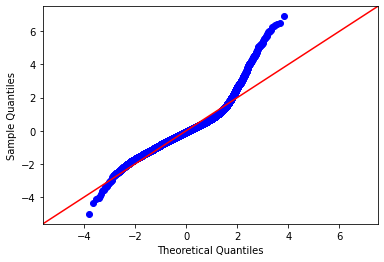

In [16]:
qqplot(model)


In order to determine the next steps of the process, we need to look at how each variable performed within the first model. Below you can see the regression plot showing residual analysis for the continuous variables.

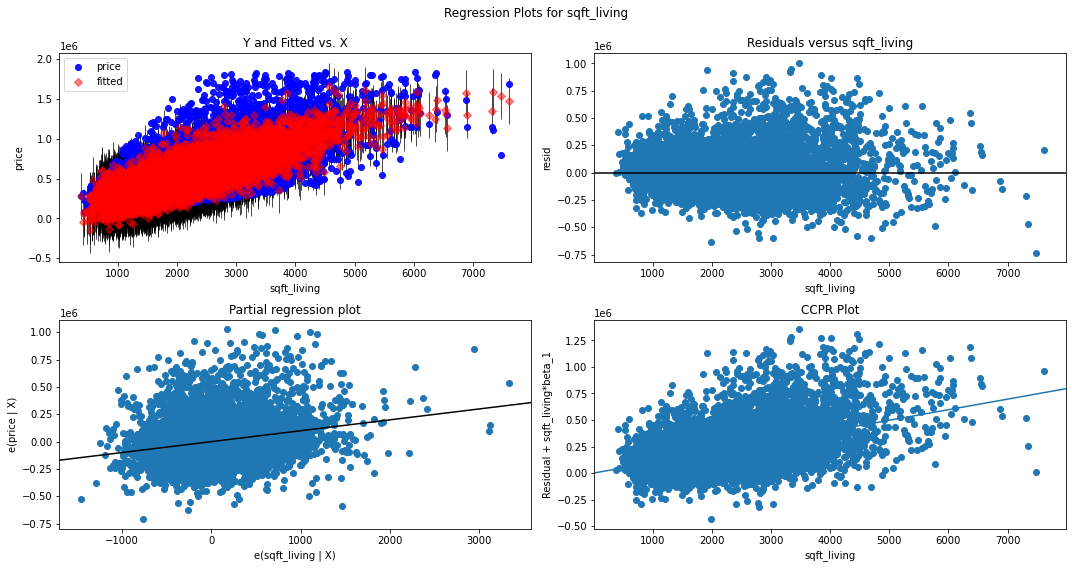

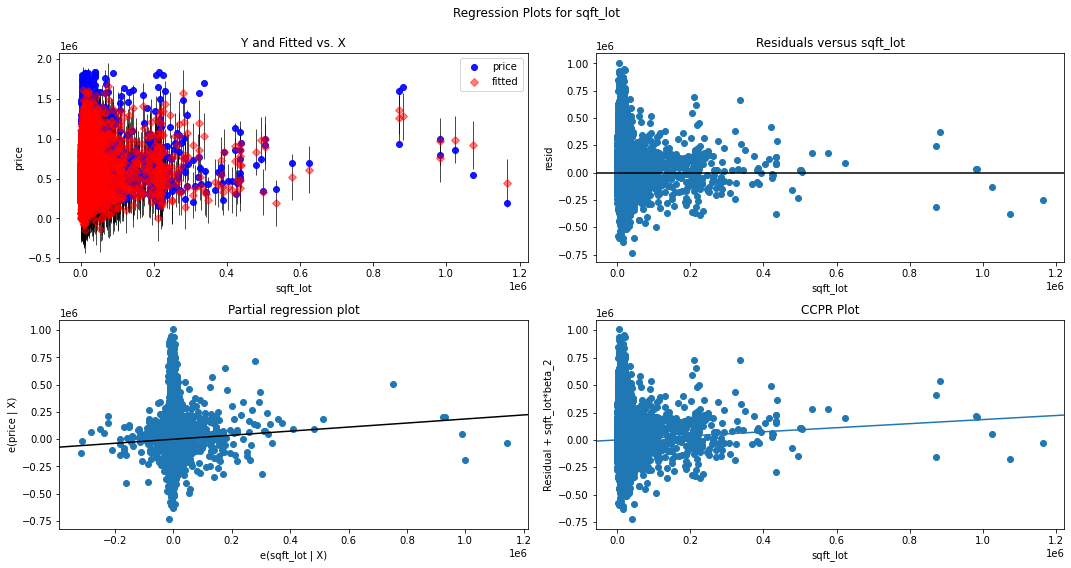

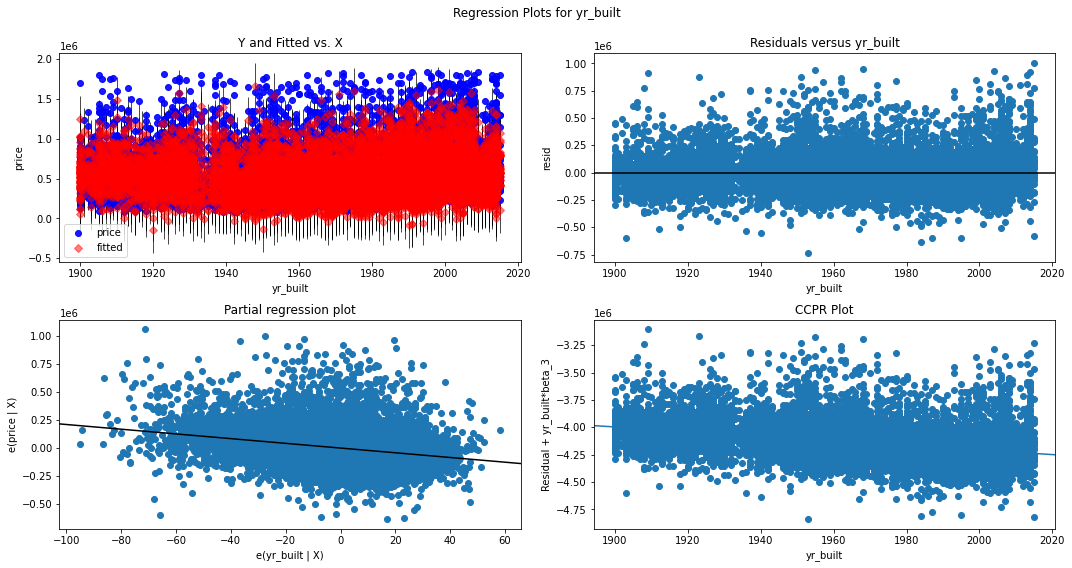

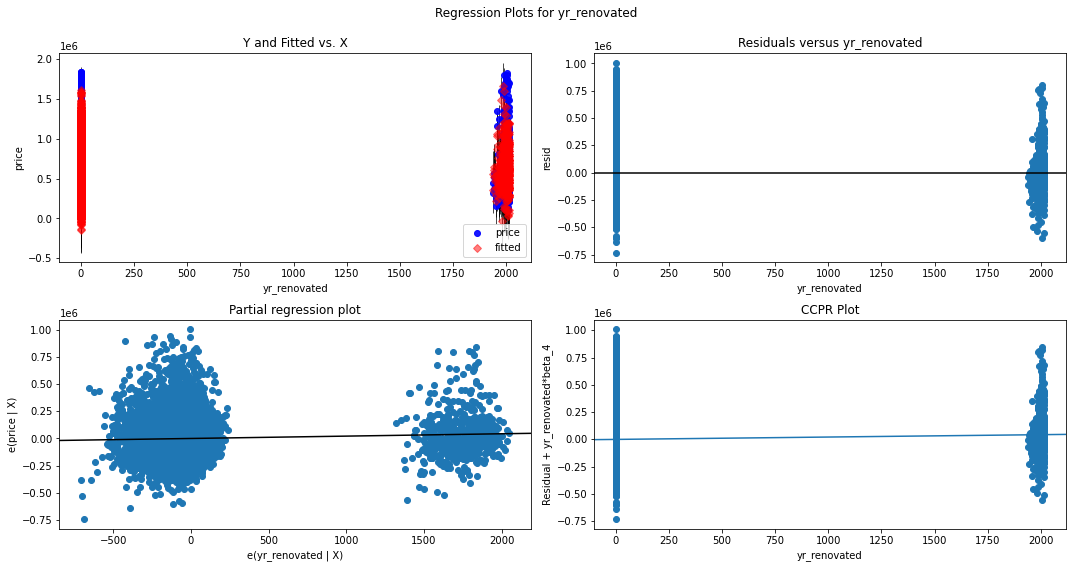

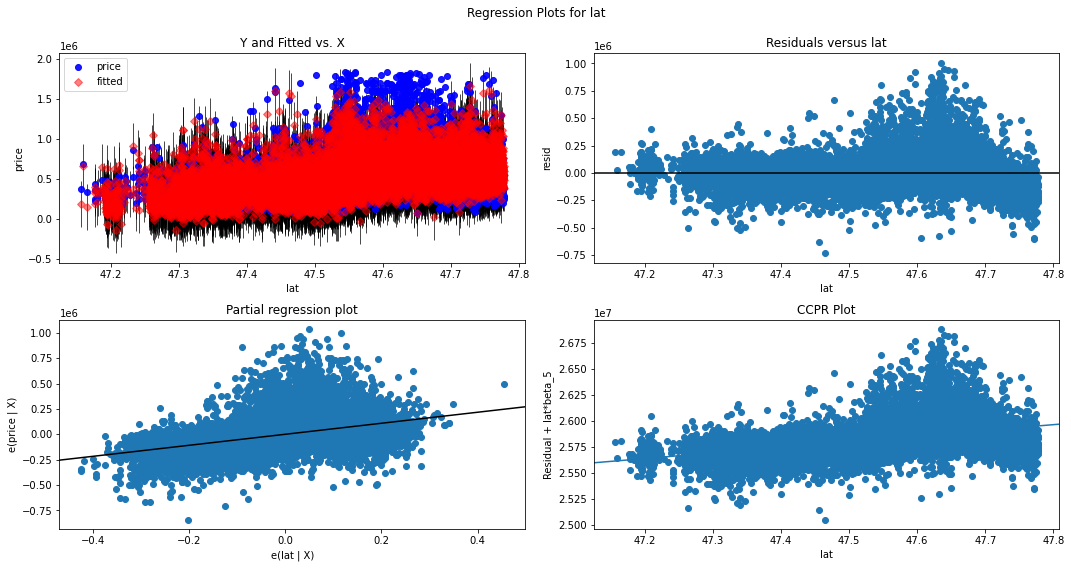

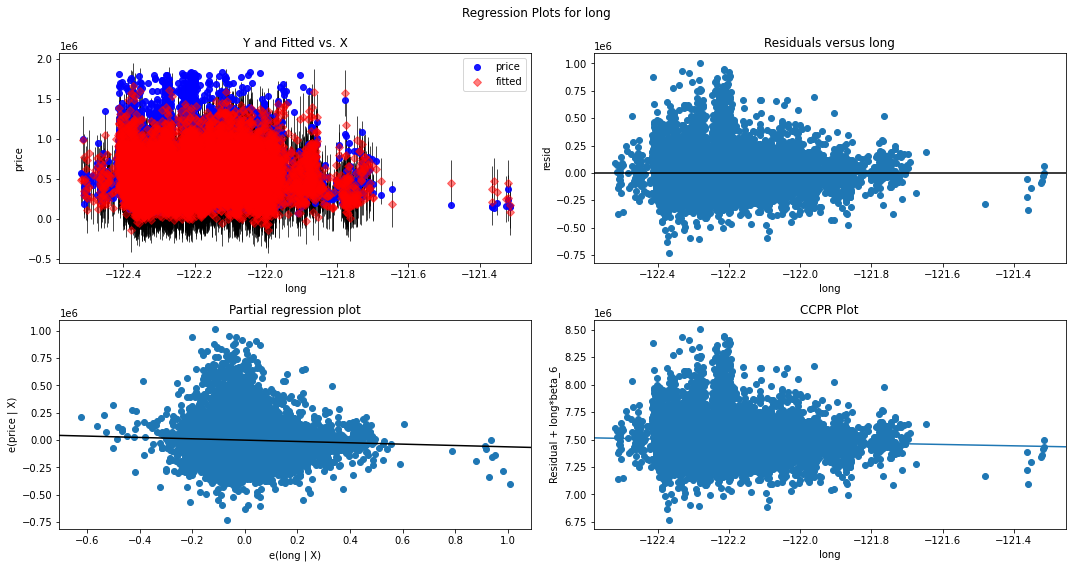

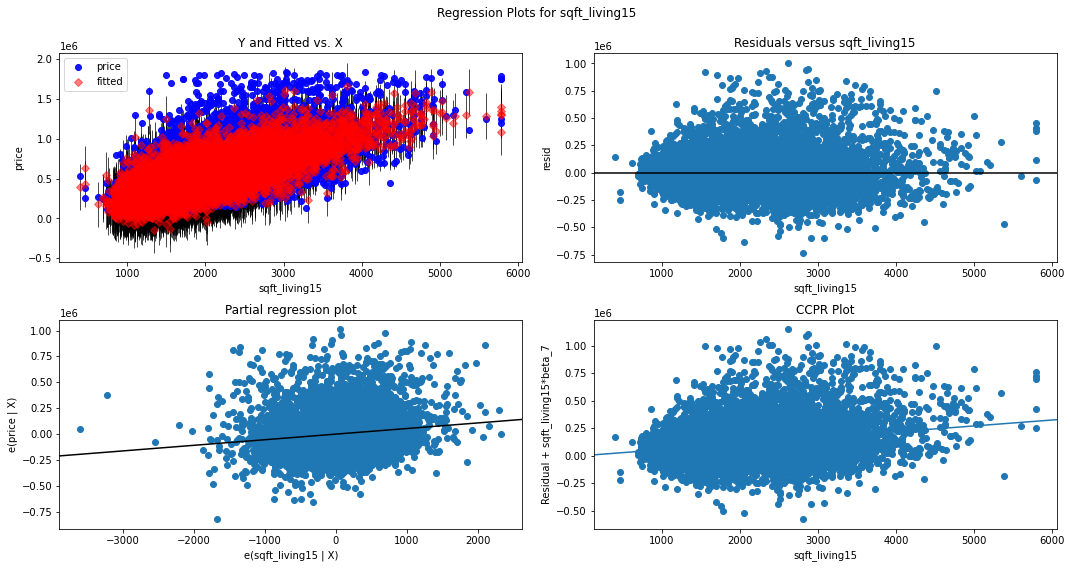

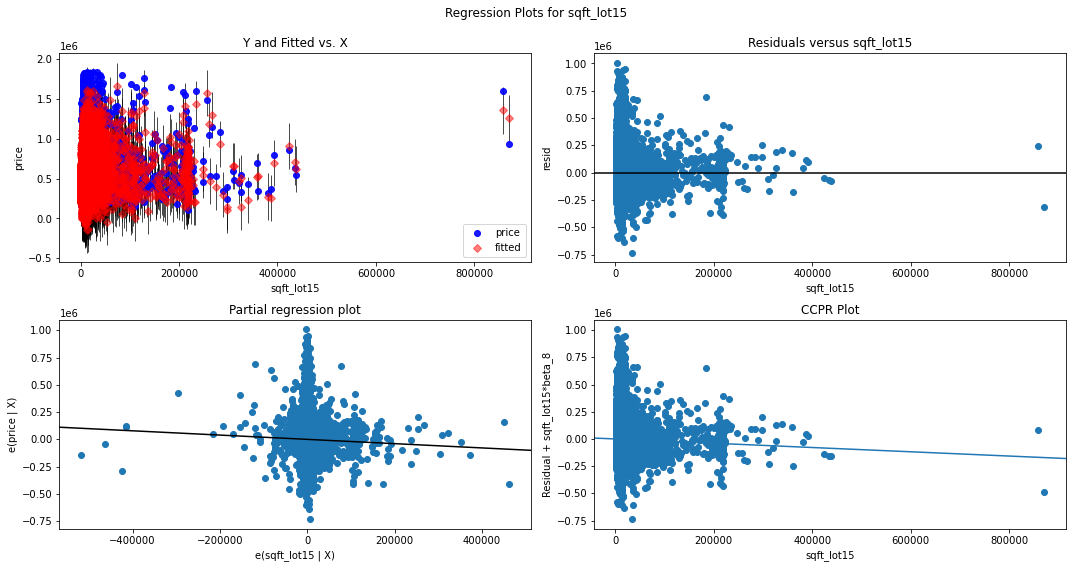

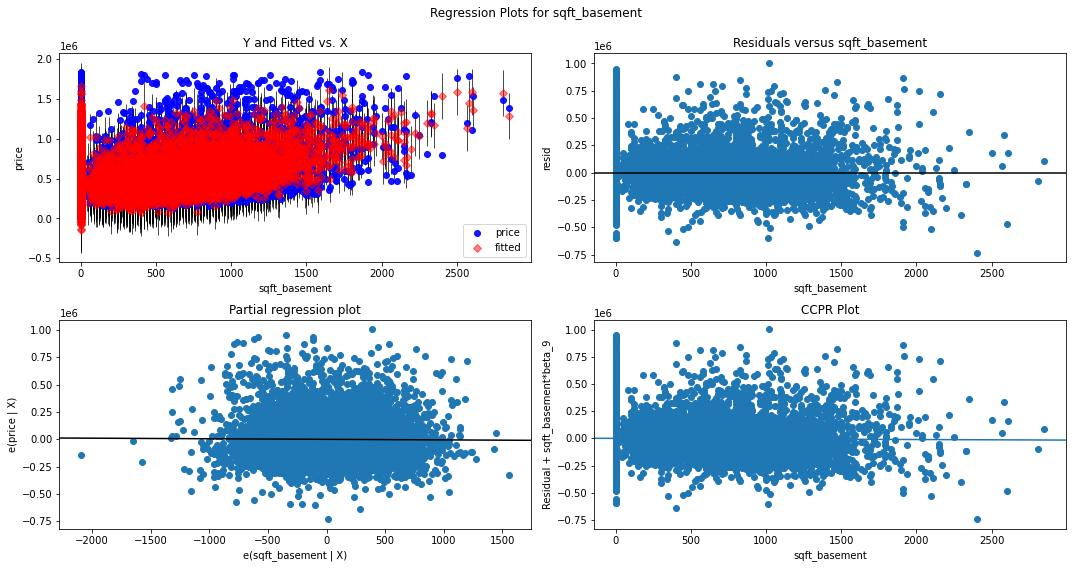

In [17]:
regress_plots(continuous,model)

As we can see, there is a strong case that the sqft_living variable is heteroscedastic and will throw off our model considerably. One of the possible causes is that, as housing price increases, it follows a logarithmic pattern. The first possible remedy is to log transform some of the variables to see if the outliers reduce their influence. Below you can see the histogram of the sqft_living variable and the price outcome variable next to the log transformation of that data:

The hetroscedasticity of some of the variables is observable and will throw off our model greatly. One of the possible causes is that as the Price increases some of the variables follow a logarithmic pattern. Hence, coming to our first fix to be the log transformation of those variables including the price to see if the outliers would reduce thier influence. Below is a sample histogram of sqft_living and log transformation of that data.

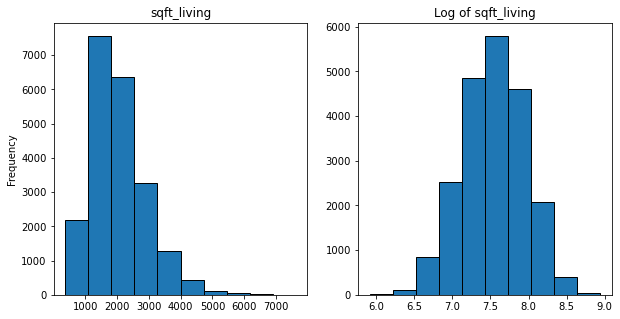

In [18]:
log_transform(df,'sqft_living')

And if we apply the same transformation to the Price column, we can see that it takes a heavily skewed dataset and gives it a greater degree of normalcy.

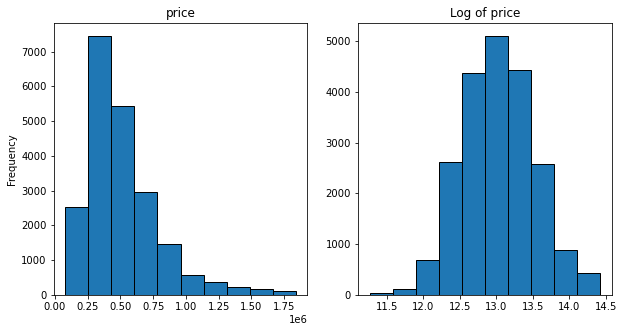

In [19]:
log_transform(df, 'price')


## Model #2: Log Transformations

The log transformation of the continuous variables should make the data distribution far more normal than is was, while also handling the outliers effectively.  Now in this next step we will observe how the log transformations of each of those variables affect the distribution.

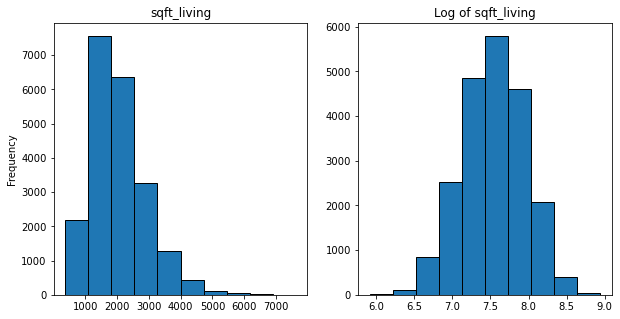

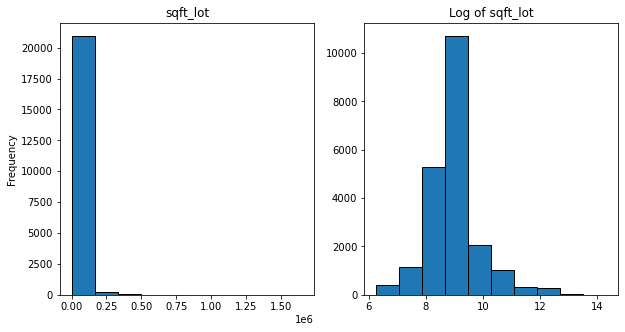

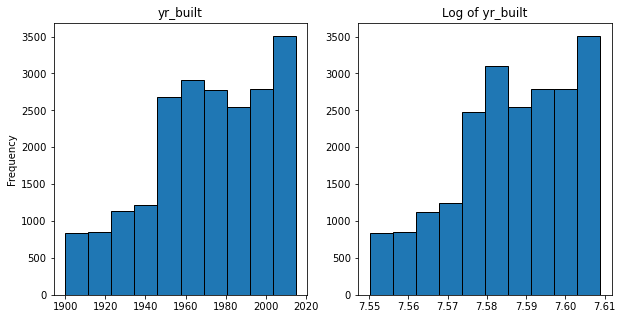

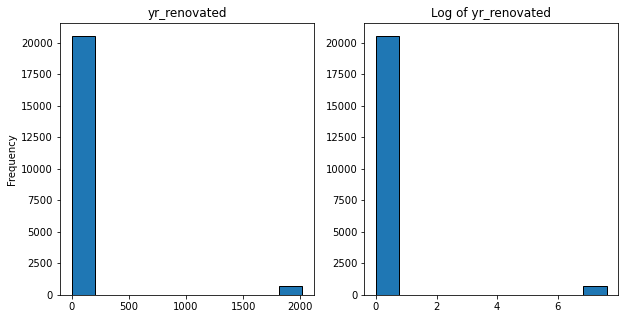

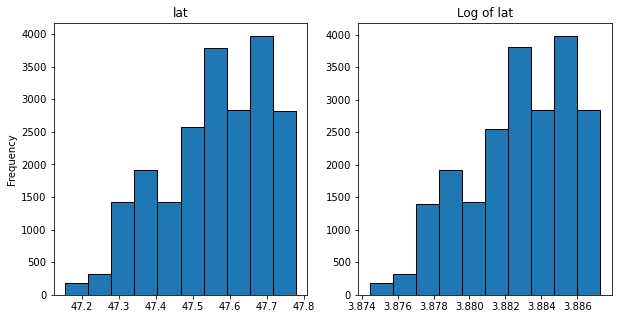

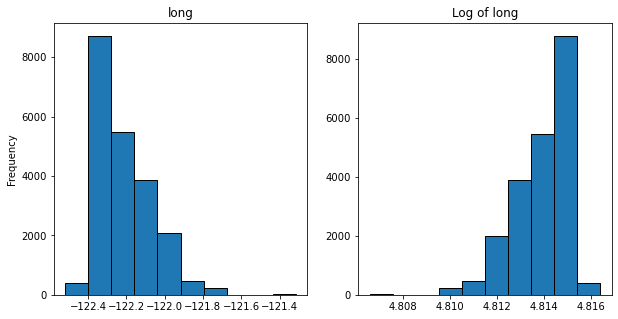

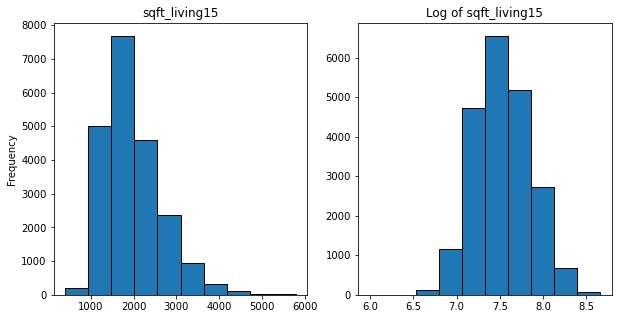

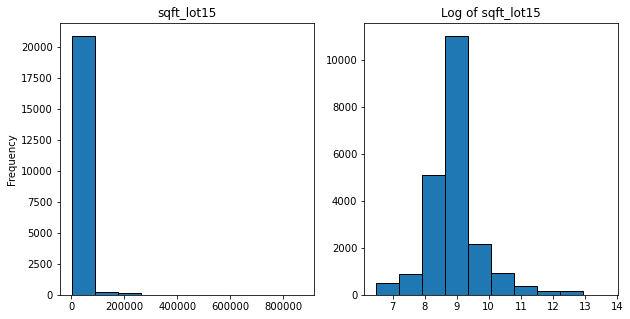

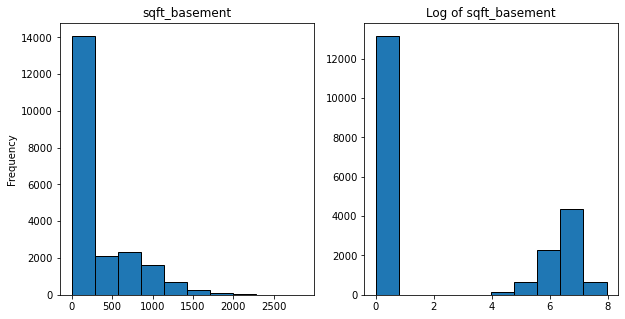

In [20]:
for column in continuous:
    log_transform(df, column)

Although with some skewness and higher kurtosis the following variables have adapted a normal distribution after transformation.

- Sqft_living
- Sqft_lot
- Sqft_living15
- Sqft_lot15
- Price


If we apply these log transformations to our model we will see if that increases our accuracy. We will not transform 'Price' at the moment, but it will be transformed in the function sk_linear_regression and then inverted in order to evaluate the Mean Absolute Error and Root Mean Squared Error scores.

In [21]:
log_cols = ['sqft_living','sqft_lot','sqft_living15','sqft_lot15']

logs = []

for x in log_cols:
    df[f'{x}_log'] = np.log(df[x])
    logs.append(f'{x}_log')
    
df_log = df.drop(columns=log_cols)

In [22]:
continuous = ['yr_built', 'yr_renovated', 'lat', 'long', 'sqft_basement']
outcome = 'price'


Training Scores:
R2: 0.7480246822120177
Root Mean Squared Error: 145609.77368866088
Mean Absolute Error: 98231.99178035177
---
Testing Scores:
R2: 0.7550648582676802
Root Mean Squared Error: 154164.30825052058
Mean Absolute Error: 99926.69830939523


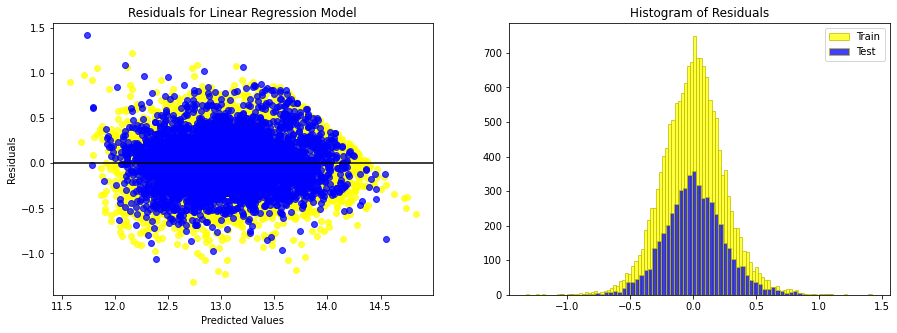

LinearRegression()

In [23]:
sk_linear_regression(df_log, continuous+logs+categorical, outcome, log=True)

### Analysis

For our second model, we can account for 75.5% of the data's variance. The model is starting to look like a good fit since our test scores and train scores vary only slightly. Our outcome data would have an error of around $154,164 which is still a lot to accurately determine the price of a property but atleast since it is lower than it was, we know we are on the right track. In the residuals plot the issue of heteroscedasticity seems to have been resolve for the moment.

Let's take a look at the Stats model summary below for more details.

In [24]:
model = sm_linear_regression(df, continuous+logs+categorical, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     2780.
Date:                Sat, 12 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:57:17   Log-Likelihood:                -293.39
No. Observations:               15935   AIC:                             622.8
Df Residuals:                   15917   BIC:                             761.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -44.6526      2.357    -18.946      0.000     -49.272     -40.033
yr_built             -0.0035      0.000    -34.233      0.000      -0.004      -0.003
yr_renovated       3.131e-05   5.78e-06      5.414      0.000       2e-05    4.26e-05
lat                   1.3163      0.015     88.010      0.000       1.287       1.346
long                  0.0291      0.017      1.663      0.096      -0.005       0.063
sqft_basement      2.935e-06   6.39e-06      0.459      0.646   -9.59e-06    1.55e-05
sqft_living_log       0.3296      0.012     28.103      0.000       0.307       0.353
sqft_lot_log          0.0174      0.006      3.026      0.002       0.006       0.029
sqft_living15_log     0.2392      0.010     23.575      0.000       0.219       0.259
sqft_lot15_log       -0.0455      0.006     -7.272      0.000      -0.058      -0.033
bedrooms             -0.0271      0.003     -9.122      0.000      -0.033      -0.021
bathrooms             0.0605      0.005     12.757      0.000       0.051       0.070
view                  0.0604      0.003     19.508      0.000       0.054       0.066
floors                0.0560      0.006     10.136      0.000       0.045       0.067
waterfront            0.2729      0.029      9.476      0.000       0.216       0.329
condition             0.0646      0.003     19.463      0.000       0.058       0.071
grade                 0.1556      0.003     51.740      0.000       0.150       0.161
month                -0.0050      0.001     -7.888      0.000      -0.006      -0.004
==============================================================================
Omnibus:                      251.518   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.671
Skew:                           0.030   Prob(JB):                    1.72e-107
Kurtosis:                       3.858   Cond. No.                     2.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Log transform Analysis and Plan of Action

From our model summary we observe an appreciable improvement in the skewness, kurtosis and R-squared. Although sqft_basement continue to resist its effect on the outcome to be of paramount significance, we could look into it more. Also in the note part of the summary we see that we still have a high chance that there is multicollinearity and must investigate variable interactions. Finally, if we check the QQplot of the model's residuals, we can see a marked upgrade over what we had before. The residuals aren't perfect yet, but we can improve on them.

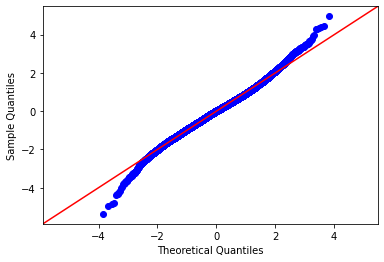

In [25]:
qqplot(model)


And let's take another look at our log transformed variables in the following regression plot. As you can see, we've removed majority of the heteroscedasticity and the residuals for those variable are starting look more normally distributed.

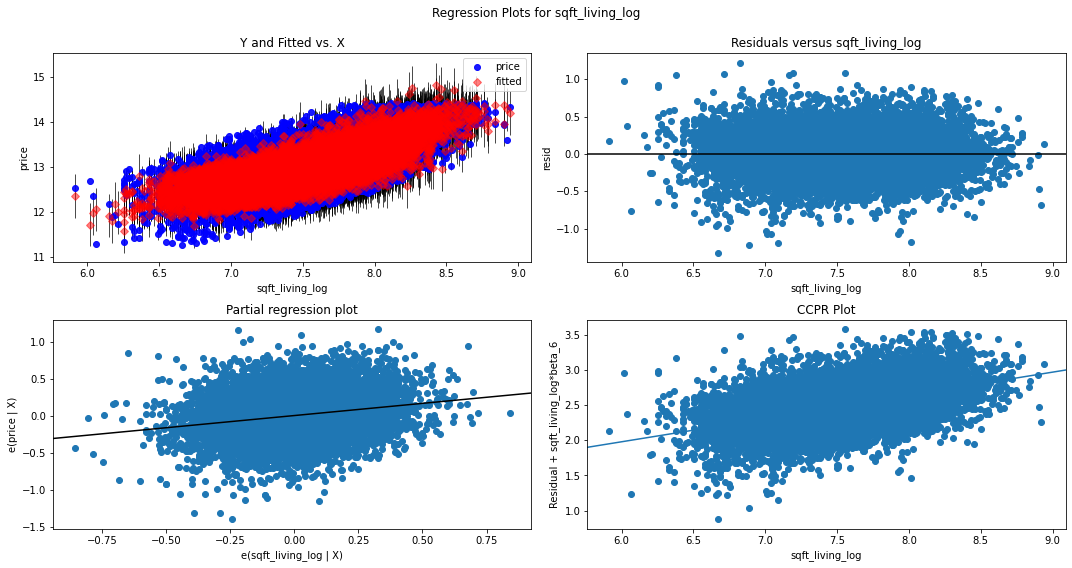

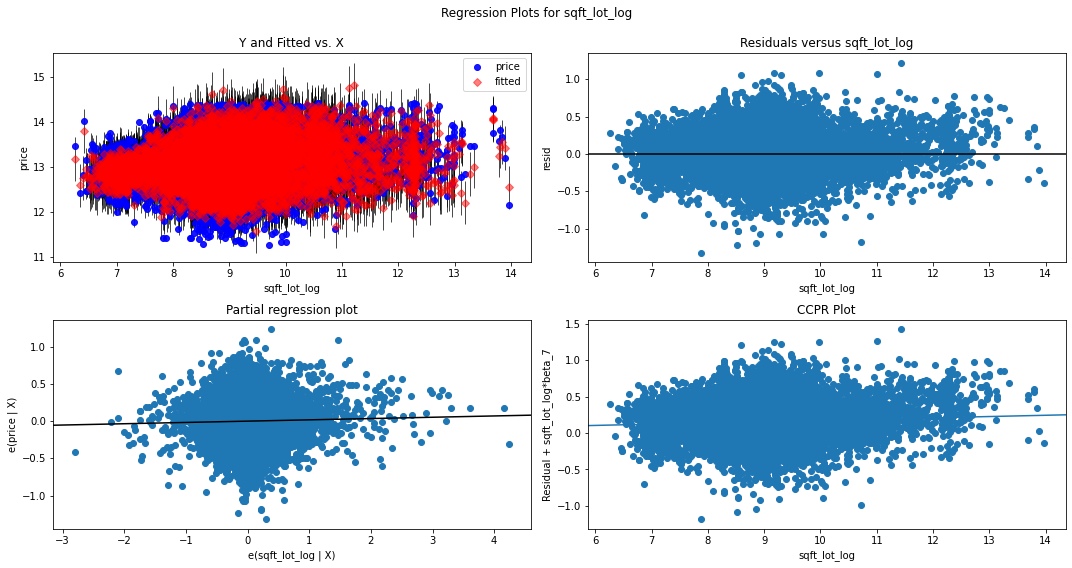

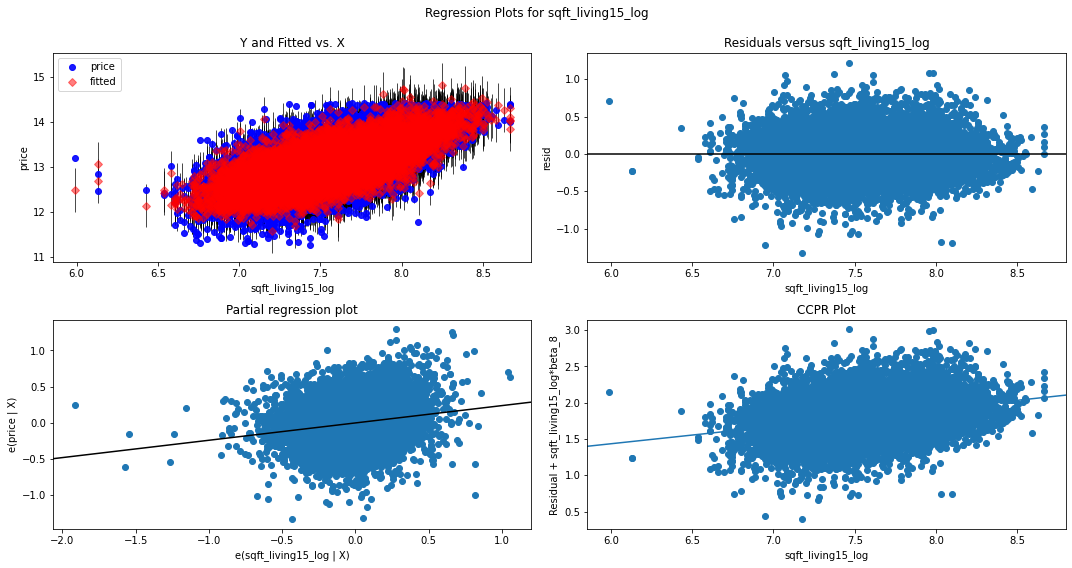

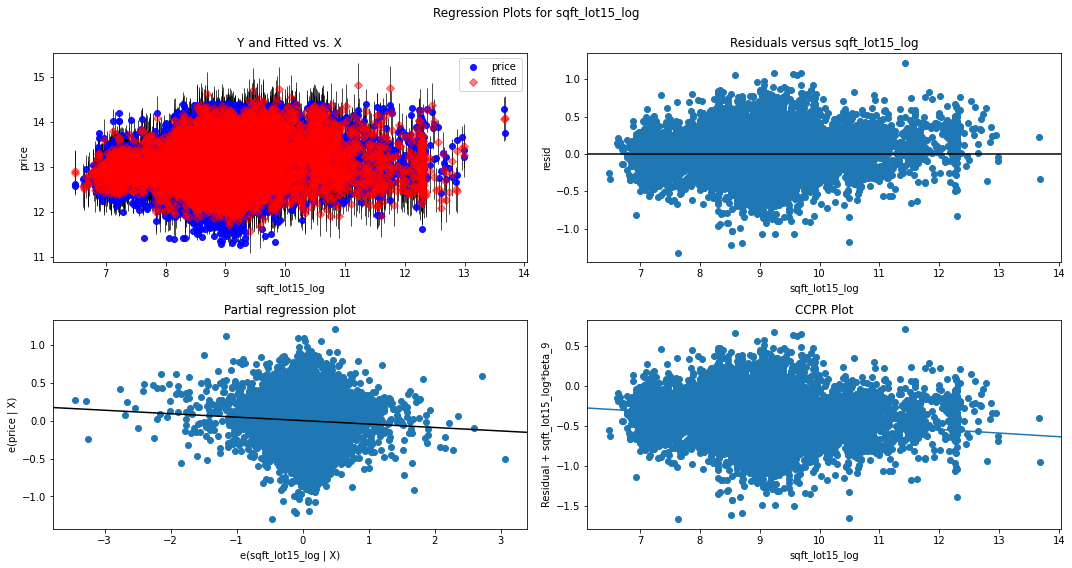

In [26]:
regress_plots(logs, model)

In the next model I will go into more details to explore the categorical variables as well.

## Model #3: One Hot Encoding Categoricals

In our previous models I was only using the continuous data and not the categorical. For this section I will be using one-hot-encoding our categoricals to make sure they are read into the model accurately. I have picked out the following variables to follow a categorical pattern:

- bedrooms
- bathrooms
- floors
- waterfront
- condition
- grade

Before going into it though I will investigate if each variable needs to be preprocessed first. Here is a break down of each variable.

In [27]:
for x in categorical:
    print(f'{x} has {df[x].nunique()} unique values')

bedrooms has 8 unique values
bathrooms has 25 unique values
view has 5 unique values
floors has 6 unique values
waterfront has 2 unique values
condition has 5 unique values
grade has 11 unique values
month has 12 unique values


As we can see above, zipcode, month and grade would have high number of categories and hence resulting in a huge number of columns to the dataframe. So I will drop the zipcode for now and use it later for exploring more on the locational aspect of the model.

Here is a review of our current variable breakdown.

In [28]:
print('Continuous columns: ', continuous)
print('Categorical columns: ', categorical)
print('Log Transformed columns: ', logs)
print('Outcome column: ', outcome)

Continuous columns:  ['yr_built', 'yr_renovated', 'lat', 'long', 'sqft_basement']
Categorical columns:  ['bedrooms', 'bathrooms', 'view', 'floors', 'waterfront', 'condition', 'grade', 'month']
Log Transformed columns:  ['sqft_living_log', 'sqft_lot_log', 'sqft_living15_log', 'sqft_lot15_log']
Outcome column:  price


For this business program we are more interested in homes for single family and I am going to assume that our Real estate agency will not be interested in houses not renovated for more than 10 years. So I will create a new column 'Recent_Const' that takes in a boolean value and returns 'True' for houses built or renovated after 2005.


In [29]:
df['Recent_Const'] = False
df['Recent_Const'] = df.loc[(df.yr_built >= 2005) | (df.yr_renovated >= 2005)
                           ].Recent_Const.map(lambda x: True)
df.Recent_Const.fillna(False,inplace=True)
categorical.append('Recent_Const')
continuous.remove('yr_built')
continuous.remove('yr_renovated')


We can now One Hot Encode the following columns while dropping the first column to ensure we don't cause any further multicollinearity. We will build these new columns using the Pandas get_dummies function.

In [30]:
cat_df = []

for column in categorical:
    cat_df.append(pd.get_dummies(df[column], prefix=column, drop_first=True))

ohe_df = pd.concat(cat_df, axis=1)

ohe_cols = ohe_df.columns.to_list()

df_ohe1 = pd.concat([df, ohe_df], axis=1)


Now that we have those categorical variables one hot encoded we can see how this transformation has affected our model.

Training Scores:
R2: 0.7381648431818209
Root Mean Squared Error: 147943.475588901
Mean Absolute Error: 100569.24286606789
---
Testing Scores:
R2: 0.7440835724201365
Root Mean Squared Error: 156890.28819134014
Mean Absolute Error: 103476.55985435126


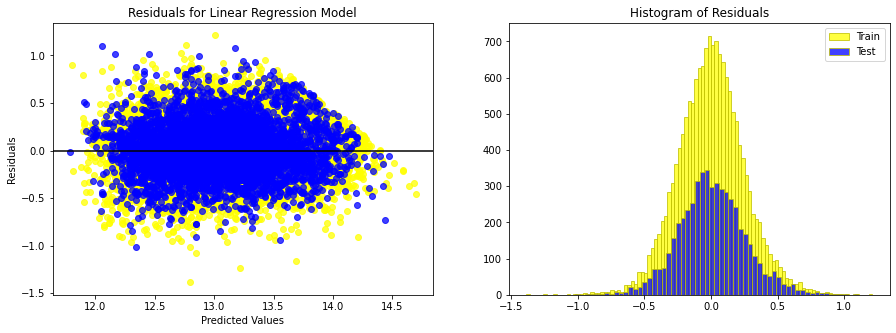

LinearRegression()

In [31]:
predictors = continuous + ohe_cols + logs
sk_linear_regression(df_ohe1, predictors, outcome, log=True)

### Analysis

Taking a look at how our 3rd model performed, we can account for 74.4% of the data's variance. Model looks slightly over fit with higher test score and train scores. Our data would have an error of around $156,890 which is a little more than our last model but we could still do better. Homoscedastcity is visible in the spread of the residuals.

Let's take a look at the Stats model summary below for more details.

In [32]:
model = sm_linear_regression(df_ohe1, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     604.2
Date:                Sat, 12 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:57:23   Log-Likelihood:                -599.22
No. Observations:               15935   AIC:                             1348.
Df Residuals:                   15860   BIC:                             1924.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -73.5375      2.246    -32.748      0.000     -77.939     -69.136
lat                   1.4036      0.015     92.541      0.000       1.374       1.433
long                 -0.1247      0.017     -7.196      0.000      -0.159      -0.091
sqft_basement       6.67e-06   6.81e-06      0.980      0.327   -6.67e-06       2e-05
bedrooms_2           -0.0316      0.022     -1.417      0.156      -0.075       0.012
bedrooms_3           -0.0956      0.022     -4.250      0.000      -0.140      -0.052
bedrooms_4           -0.1107      0.023     -4.791      0.000      -0.156      -0.065
bedrooms_5           -0.1305      0.024     -5.361      0.000      -0.178      -0.083
bedrooms_6           -0.1210      0.030     -4.029      0.000      -0.180      -0.062
bedrooms_7           -0.2364      0.059     -3.988      0.000      -0.353      -0.120
bedrooms_8           -0.0703      0.088     -0.800      0.424      -0.243       0.102
bathrooms_0.75        0.3620      0.150      2.409      0.016       0.068       0.657
bathrooms_1.0         0.3426      0.146      2.351      0.019       0.057       0.628
bathrooms_1.25        0.2949      0.179      1.651      0.099      -0.055       0.645
bathrooms_1.5         0.3238      0.146      2.220      0.026       0.038       0.610
bathrooms_1.75        0.3431      0.146      2.353      0.019       0.057       0.629
bathrooms_2.0         0.3565      0.146      2.444      0.015       0.071       0.642
bathrooms_2.25        0.3378      0.146      2.316      0.021       0.052       0.624
bathrooms_2.5         0.3155      0.146      2.163      0.031       0.030       0.601
bathrooms_2.75        0.3484      0.146      2.386      0.017       0.062       0.635
bathrooms_3.0         0.3725      0.146      2.548      0.011       0.086       0.659
bathrooms_3.25        0.4011      0.146      2.739      0.006       0.114       0.688
bathrooms_3.5         0.4080      0.146      2.788      0.005       0.121       0.695
bathrooms_3.75        0.4775      0.148      3.224      0.001       0.187       0.768
bathrooms_4.0         0.4402      0.149      2.962      0.003       0.149       0.732
bathrooms_4.25        0.4547      0.151      3.012      0.003       0.159       0.751
bathrooms_4.5         0.4626      0.150      3.087      0.002       0.169       0.756
bathrooms_4.75        0.4579      0.179      2.559      0.010       0.107       0.809
bathrooms_5.0         0.5227      0.161      3.242      0.001       0.207       0.839
bathrooms_5.25        0.4800      0.193      2.481      0.013       0.101       0.859
bathrooms_5.5         0.5395      0.207      2.604      0.009       0.133       0.946
bathrooms_5.75       -0.0933      0.297     -0.314      0.753      -0.675       0.488
bathrooms_6.0         0.4084      0.295      1.383      0.167      -0.171

### One Hot Encoding Analysis and Plan of Action

We can see that our data distribution is fairly normal at this point and the kurtosis hasn't changed much but is still close to a normal distribution with less extreme values. However, we need to reassess this current categorical set up (and drop the 'sqft_basement') because, as we can see from the summary, there are a number of variables with a p value greater than our alpha of 0.05, meaning we cannot reject the null hypothesis that they have zero effect on the outcome(price). This is a good indication that our categorical variables need some help.
Finally, if we check the QQplot of the model the residuals aren't perfect yet, notably need some more work.

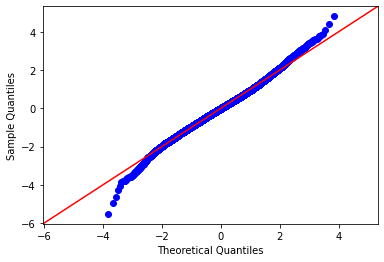

In [33]:
qqplot(model)


That's looking a little better! While our model isn't any more accurate, we are getting closer. We're going to reassess those categoricals next. Let's drop 'sqft_basement' from our continuous variables before moving on to the next step.

In [34]:
continuous = ['lat', 'long']

## Model #4: Bining categorical variables

In the previous model the categorical variables have outnumbered our continous variables. Since this could affect our model's performance I will try and consider binning some of the categorical variables to reduce the number of columns. I will deal with zipcode in the next model for locational data modeling.

For each column in the categorical list I will create bins with the following specifications according to the quartiles. The whole purpose of this is to weigh our data in such a manner that it doesn't disturb the normality of the distribution. A statistical description of the columns will be our bench mark to determine our boundaries for our bins.

In [35]:
df[categorical].describe()

,bedrooms,bathrooms,view,floors,waterfront,condition,grade,month
count,21247.000000,21247.000000,21247.000000,21247.000000,21247.000000,21247.000000,21247.000000,21247.000000
mean,3.356568,2.094190,0.212171,1.489034,0.005130,3.408622,7.620229,6.577682
std,0.886866,0.740771,0.721163,0.538827,0.071443,0.649489,1.125652,3.113449
min,1.000000,0.500000,0.000000,1.000000,0.000000,1.000000,3.000000,1.000000
25%,3.000000,1.500000,0.000000,1.000000,0.000000,3.000000,7.000000,4.000000
50%,3.000000,2.250000,0.000000,1.500000,0.000000,3.000000,7.000000,6.000000
75%,4.000000,2.500000,0.000000,2.000000,0.000000,4.000000,8.000000,9.000000
max,8.000000,6.750000,4.000000,3.500000,1.000000,5.000000,13.000000,12.000000


Another point I would want to make is, considering we are dealing with only single family houses, I will only examine houses which satisfy the standard bathrooms per bedroom being 2 to 3. So for this analysis I will exclude houses with less than 1 bathroom. May be this could have had something to do with our outliers in the QQ plot. 


We will see.


In [36]:
df.shape

(21247, 26)

In [37]:
#consider houses with one or more bathrooms
df = df.loc[df['bathrooms'] >= 1]

From our categories 'view' doesn't seem to be feasible for transforming into a continous variable. Also we will not need to process waterfront since it is a boolean value.

In [38]:
df.shape

(21172, 26)

We can see we have dropped 75 rows, which is ok since it is small compared to our data.


Based on this breakdown, the mid-range of each variable would be:

- Bedrooms       - 3-4 bedrooms
- Bathrooms      - 1.5-2.5 bathrooms
- Condition      - 3-4
- Grade          - 7-8
- yrs_reno  - 10 years


- **Floors**
* 1-1.5 Floors = Small
* 2-2.5 Floors = Medium
* 3+ Floors = Big

Just to review our categorical and continuous list again:

In [39]:
continuous

['lat', 'long']

In [40]:
categorical

['bedrooms',
 'bathrooms',
 'view',
 'floors',
 'waterfront',
 'condition',
 'grade',
 'month',
 'Recent_Const']

In [41]:
df[categorical].describe()

,bedrooms,bathrooms,view,floors,waterfront,condition,grade,month
count,21172.000000,21172.000000,21172.000000,21172.000000,21172.000000,21172.000000,21172.000000,21172.000000
mean,3.361657,2.098999,0.211553,1.490459,0.004912,3.408417,7.627149,6.577839
std,0.882813,0.737647,0.720013,0.539042,0.069916,0.648715,1.119743,3.113057
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,4.000000,1.000000
25%,3.000000,1.750000,0.000000,1.000000,0.000000,3.000000,7.000000,4.000000
50%,3.000000,2.250000,0.000000,1.500000,0.000000,3.000000,7.000000,6.000000
75%,4.000000,2.500000,0.000000,2.000000,0.000000,4.000000,8.000000,9.000000
max,8.000000,6.750000,4.000000,3.500000,1.000000,5.000000,13.000000,12.000000


In [42]:
def floors(value):
    
    if value == 1:
        return '1'
    elif value == 1.5:
        return '1.5'
    elif 2 <= value <= 2.5:
        return '2 & 2.5'
    else:
        return '3.5'

In [43]:
df['Floors'] = df.floors.map(lambda x: floors(x))
df.Floors.value_counts()

1          10527
2 & 2.5     8153
1.5         1883
3.5          609
Name: Floors, dtype: int64

In [44]:
def bathrooms(value):
    if value <= 2.25:
        return 'bel_2.25'
    elif value == 2.5:
        return '2.25'
    else:
        return 'abv_2.25'

In [45]:
df['Baths'] = df.bathrooms.map(lambda x: bathrooms(x))
df.Baths.value_counts()

bel_2.25    12273
2.25         5334
abv_2.25     3565
Name: Baths, dtype: int64

In [46]:
def bedrooms(value):
    if value < 3:
        return 'bel_3'
    elif  value == 3:
        return '3'
    elif value == 4:
        return '4'
    elif value == 5:
        return '5'
    else:
        return 'abv_5'

In [47]:
df['Beds'] = df.bedrooms.map(lambda x: bedrooms(x))
df.Beds.value_counts()

3        9732
4        6732
bel_3    2891
5        1519
abv_5     298
Name: Beds, dtype: int64

In [48]:
def condition(value):
    if value < 3:
        return 'bel_3'
    elif value == 3:
        return '3'
    elif value == 4:
        return '4'
    else:
        return 'abv_4'

In [49]:
df['Cond'] = df.condition.map(lambda x: condition(x))
df.Cond.value_counts()

3        13762
4         5569
abv_4     1649
bel_3      192
Name: Cond, dtype: int64

In [50]:
def grade(value):
    if value < 7:
        return 'bel_7'
    elif value == 7:
        return '7'
    elif value == 8:
        return '8'
    elif value == 9:
        return '9'
    else:
        return 'abv_9'

In [51]:
df['Grade'] = df.grade.map(lambda x: grade(x))
df.Grade.value_counts()

7        8922
8        6039
9        2567
bel_7    2244
abv_9    1400
Name: Grade, dtype: int64

In [52]:
def month(value):
    if 3 <= value <= 5:
        return 'Spring'
    elif 6 <= value <= 8:
        return 'Summer'
    elif 9 <= value <= 11:
        return 'Fall'
    else:
        return 'Winter'

In [53]:
df['Month'] = df.month.map(lambda x: month(x))
df.month.value_counts()

5     2359
4     2187
7     2178
6     2139
8     1898
10    1840
3     1833
9     1739
12    1437
11    1388
2     1223
1      951
Name: month, dtype: int64

In [54]:
new_cats = ['Grade', 'Cond', 'Beds', 'Baths', 'Floors', 
            'waterfront', 'Recent_Const', 'Month']

In [55]:
cat_dfs = []

for column in new_cats:
    cat_dfs.append(pd.get_dummies(df[column], 
                                  prefix=column[:3], drop_first=True))

ohe_df = pd.concat(cat_dfs, axis=1)
ohe_cols = ohe_df.columns.to_list()

df_ohe2 = pd.concat([df, ohe_df], axis=1)

In [56]:
ohe_cols

['Gra_8',
 'Gra_9',
 'Gra_abv_9',
 'Gra_bel_7',
 'Con_4',
 'Con_abv_4',
 'Con_bel_3',
 'Bed_4',
 'Bed_5',
 'Bed_abv_5',
 'Bed_bel_3',
 'Bat_abv_2.25',
 'Bat_bel_2.25',
 'Flo_1.5',
 'Flo_2 & 2.5',
 'Flo_3.5',
 'wat_1.0',
 'Rec_True',
 'Mon_Spring',
 'Mon_Summer',
 'Mon_Winter']

In [57]:
df_ohe2.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'month', 'year', 'waterfront', 'sqft_living_log', 'sqft_lot_log',
       'sqft_living15_log', 'sqft_lot15_log', 'Recent_Const', 'Floors',
       'Baths', 'Beds', 'Cond', 'Grade', 'Month', 'Gra_8', 'Gra_9',
       'Gra_abv_9', 'Gra_bel_7', 'Con_4', 'Con_abv_4', 'Con_bel_3', 'Bed_4',
       'Bed_5', 'Bed_abv_5', 'Bed_bel_3', 'Bat_abv_2.25', 'Bat_bel_2.25',
       'Flo_1.5', 'Flo_2 & 2.5', 'Flo_3.5', 'wat_1.0', 'Rec_True',
       'Mon_Spring', 'Mon_Summer', 'Mon_Winter'],
      dtype='object')

In [58]:
df_ohe2.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'month', 'year', 'waterfront', 'sqft_living_log', 'sqft_lot_log',
       'sqft_living15_log', 'sqft_lot15_log', 'Recent_Const', 'Floors',
       'Baths', 'Beds', 'Cond', 'Grade', 'Month', 'Gra_8', 'Gra_9',
       'Gra_abv_9', 'Gra_bel_7', 'Con_4', 'Con_abv_4', 'Con_bel_3', 'Bed_4',
       'Bed_5', 'Bed_abv_5', 'Bed_bel_3', 'Bat_abv_2.25', 'Bat_bel_2.25',
       'Flo_1.5', 'Flo_2 & 2.5', 'Flo_3.5', 'wat_1.0', 'Rec_True',
       'Mon_Spring', 'Mon_Summer', 'Mon_Winter'],
      dtype='object')

Training Scores:
R2: 0.7280664343493003
Root Mean Squared Error: 154430.91438555118
Mean Absolute Error: 105119.7113755873
---
Testing Scores:
R2: 0.7213503677503541
Root Mean Squared Error: 155312.36498580888
Mean Absolute Error: 105317.4201808292


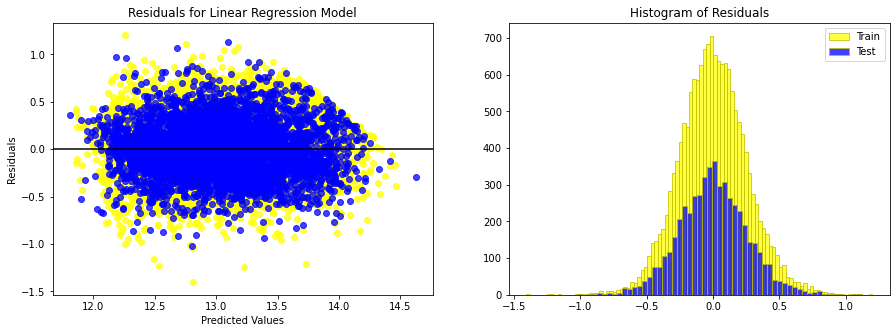

LinearRegression()

In [59]:
predictors = continuous + ohe_cols + logs
sk_linear_regression(df_ohe2, predictors, outcome, log=True)

### Analysis

In this model we seem to have taken a step back at our R score and hence only account for 71.7% of our data's variance. Our RMSE has increased as well meaning our data would have an error of around $157,739. Noticing the normalcy of the residuals however gives some peace in mind that the categorical variables were indeed not able to disturb the homoscedasticity. The stats model summary below will give us more details.

In [60]:
model = sm_linear_regression(df_ohe2, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     1572.
Date:                Sat, 12 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:57:24   Log-Likelihood:                -978.85
No. Observations:               15879   AIC:                             2014.
Df Residuals:                   15851   BIC:                             2229.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -84.1280      2.203    -38.187      0.000     -88.446     -79.810
lat                   1.4050      0.015     91.087      0.000       1.375       1.435
long                 -0.2071      0.017    -12.039      0.000      -0.241      -0.173
Gra_8                 0.1465      0.006     25.296      0.000       0.135       0.158
Gra_9                 0.3249      0.009     37.338      0.000       0.308       0.342
Gra_abv_9             0.4852      0.012     42.042      0.000       0.463       0.508
Gra_bel_7            -0.1232      0.008    -15.784      0.000      -0.138      -0.108
Con_4                 0.0920      0.005     18.073      0.000       0.082       0.102
Con_abv_4             0.1906      0.008     23.573      0.000       0.175       0.206
Con_bel_3            -0.1255      0.022     -5.649      0.000      -0.169      -0.082
Bed_4                -0.0222      0.005     -4.186      0.000      -0.033      -0.012
Bed_5                -0.0357      0.009     -3.927      0.000      -0.053      -0.018
Bed_abv_5            -0.0338      0.018     -1.847      0.065      -0.070       0.002
Bed_bel_3             0.0810      0.007     11.376      0.000       0.067       0.095
Bat_abv_2.25          0.0859      0.007     12.232      0.000       0.072       0.100
Bat_bel_2.25          0.0328      0.006      5.197      0.000       0.020       0.045
Flo_1.5               0.1160      0.008     15.310      0.000       0.101       0.131
Flo_2 & 2.5           0.0136      0.006      2.227      0.026       0.002       0.025
Flo_3.5               0.0142      0.014      1.002      0.316      -0.014       0.042
wat_1.0               0.4690      0.030     15.402      0.000       0.409       0.529
Rec_True              0.0170      0.007      2.480      0.013       0.004       0.030
Mon_Spring            0.0497      0.006      8.808      0.000       0.039       0.061
Mon_Summer            0.0019      0.006      0.335      0.738      -0.009       0.013
Mon_Winter           -0.0101      0.007     -1.545      0.122      -0.023       0.003
sqft_living_log       0.4027      0.011     37.996      0.000       0.382       0.423
sqft_lot_log          0.0366      0.006      6.030      0.000       0.025       0.048
sqft_living15_log     0.2577      0.011     24.191      0.000       0.237       0.279
sqft_lot15_log       -0.0542      0.007     -8.255      0.000      -0.067      -0.041
==============================================================================
Omnibus:                      166.203   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              270.858
Skew:                           0.067   Prob(JB):                     1.53e-59
Kurtosis:                       3.626   Cond. No.                     1.42e+05
======================

### Bining and Plan of Action

From the summary the skewness and kurtosis haven't changed much but our R2 has been reduced to 0.724.
Finally, if we check the QQplot of the model the residuals are as normally distributed except on the lower end signifying some outliers or multicollinearity.

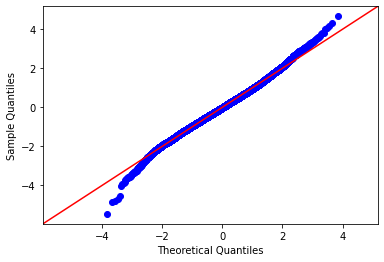

In [61]:
qqplot(model)

## Model #5: Variable Correlations

In a model like this, multicollinearity can be a huge problem because we want to know how each variable affects our outcome metric and to confirm that, we need to ensure that the variables are independent. First, we can examine the correlations between our variables using a heat map. Let's examine the continuous variables first:

<AxesSubplot:>

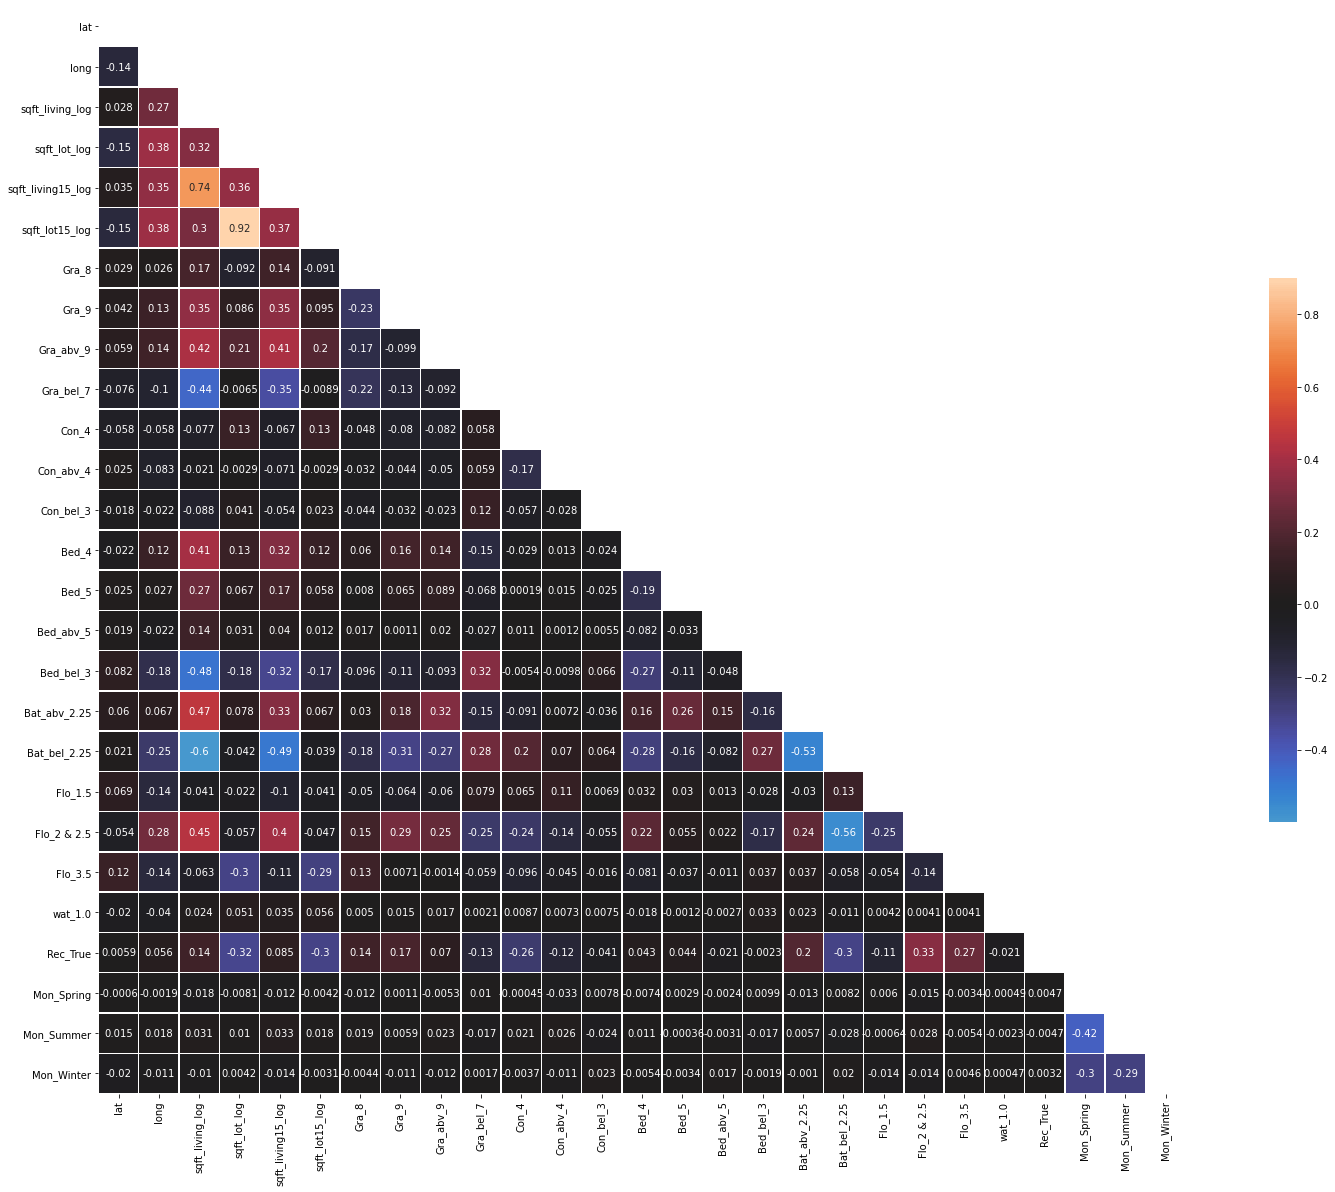

In [62]:
# Compute the correlation matrix
corr = df_ohe2[continuous+logs+ohe_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr.abs(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30,20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.9, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Analysis


Any correlation coefficient greater than 0.70 could cause issues. We can see a few issues immediately, all of which make a reasonable amount of sense:

- sqft_lot_log vs. sqft_lot15_log = 0.92
- sqft_living_log vs. sqft_living15_log = 0.74

If we look at sqft_lot_log (a measure of the lot's square footage) vs. sqft_lot15_log (the mean of the square footage of 15 neighbors) it tracks that homes with large lots will be located near other homes with large lots.

It's reasonable then to drop some of these columns to help the model. We can drop both the sqft_living15_log and the sqft_lot15_log columns without losing any key information.

In [63]:
logs

['sqft_living_log', 'sqft_lot_log', 'sqft_living15_log', 'sqft_lot15_log']

In [64]:
for col in ['sqft_living15_log', 'sqft_lot15_log']:
    logs.remove(col)
print(logs)

['sqft_living_log', 'sqft_lot_log']


Training Scores:
R2: 0.7175271488647941
Root Mean Squared Error: 157099.15567018682
Mean Absolute Error: 106489.82794421642
---
Testing Scores:
R2: 0.710756164006251
Root Mean Squared Error: 157276.47657120676
Mean Absolute Error: 106593.69641353218


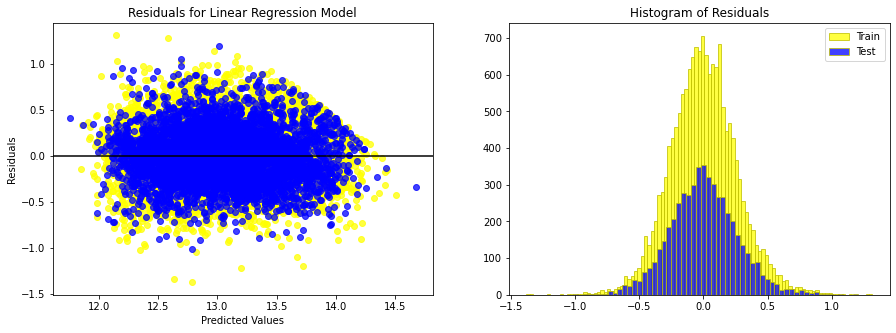

LinearRegression()

In [65]:
predictors = continuous + ohe_cols + logs
sk_linear_regression(df_ohe2, predictors, outcome, log=True)

In [66]:
model = sm_linear_regression(df_ohe2, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     1611.
Date:                Sat, 12 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:57:28   Log-Likelihood:                -1280.7
No. Observations:               15879   AIC:                             2613.
Df Residuals:                   15853   BIC:                             2813.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -77.8417      2.214    -35.160      0.000     -82.181     -73.502
lat                 1.4246      0.016     90.749      0.000       1.394       1.455
long               -0.1567      0.017     -9.065      0.000      -0.191      -0.123
Gra_8               0.1740      0.006     30.092      0.000       0.163       0.185
Gra_9               0.3762      0.009     43.948      0.000       0.359       0.393
Gra_abv_9           0.5567      0.011     49.214      0.000       0.534       0.579
Gra_bel_7          -0.1392      0.008    -17.566      0.000      -0.155      -0.124
Con_4               0.0903      0.005     17.428      0.000       0.080       0.100
Con_abv_4           0.1827      0.008     22.191      0.000       0.167       0.199
Con_bel_3          -0.1111      0.023     -4.910      0.000      -0.155      -0.067
Bed_4              -0.0191      0.005     -3.527      0.000      -0.030      -0.008
Bed_5              -0.0335      0.009     -3.613      0.000      -0.052      -0.015
Bed_abv_5          -0.0491      0.019     -2.636      0.008      -0.086      -0.013
Bed_bel_3           0.0881      0.007     12.148      0.000       0.074       0.102
Bat_abv_2.25        0.0779      0.007     10.894      0.000       0.064       0.092
Bat_bel_2.25        0.0233      0.006      3.622      0.000       0.011       0.036
Flo_1.5             0.1111      0.008     14.420      0.000       0.096       0.126
Flo_2 & 2.5         0.0126      0.006      2.038      0.042       0.000       0.025
Flo_3.5            -0.0118      0.014     -0.822      0.411      -0.040       0.016
wat_1.0             0.4817      0.031     15.539      0.000       0.421       0.543
Rec_True            0.0104      0.007      1.497      0.134      -0.003       0.024
Mon_Spring          0.0490      0.006      8.529      0.000       0.038       0.060
Mon_Summer          0.0015      0.006      0.265      0.791      -0.010       0.013
Mon_Winter         -0.0106      0.007     -1.583      0.113      -0.024       0.003
sqft_living_log     0.4959      0.010     49.212      0.000       0.476       0.516
sqft_lot_log        0.0016      0.003      0.506      0.613      -0.005       0.008
==============================================================================
Omnibus:                      238.910   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              400.706
Skew:                           0.124   Prob(JB):                     9.72e-88
Kurtosis:                       3.738   Cond. No.                     1.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that ther

A quick check on our multicollinearity after removing the highly correlated features.

<AxesSubplot:>

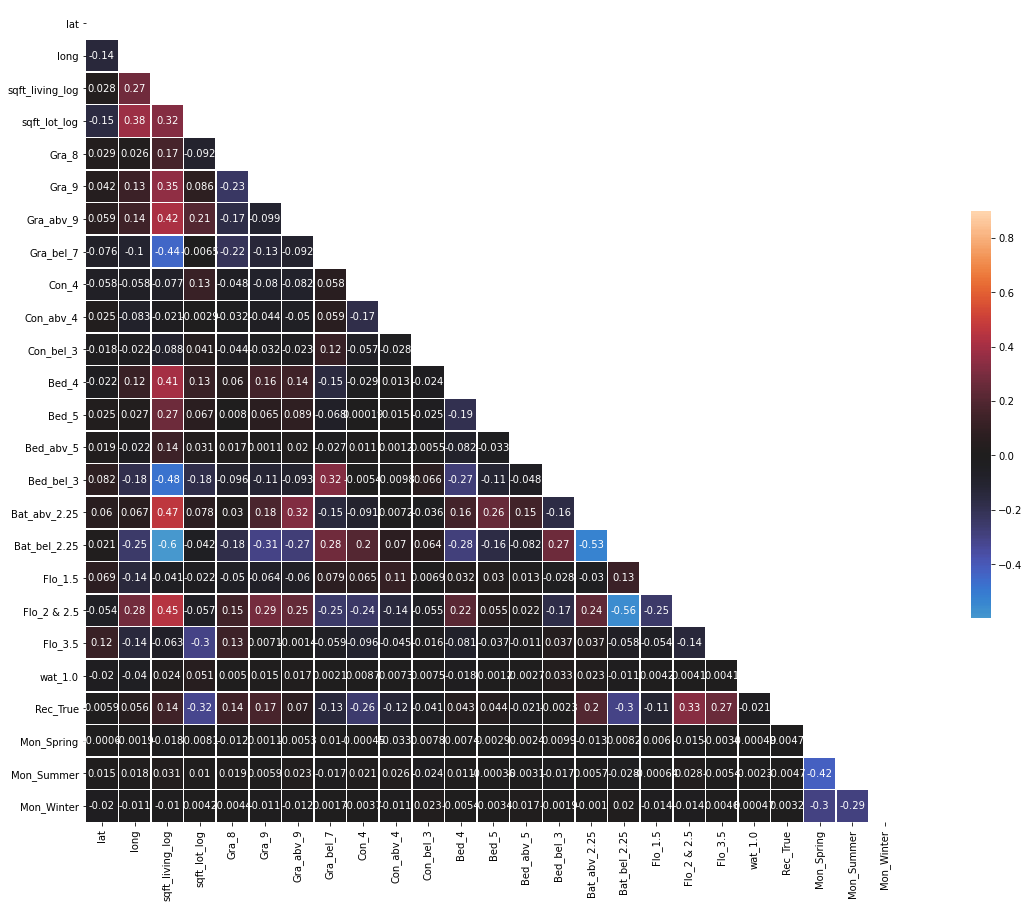

In [67]:
# Compute the correlation matrix
corr = df_ohe2[continuous+logs+ohe_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr.abs(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25,15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.9, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

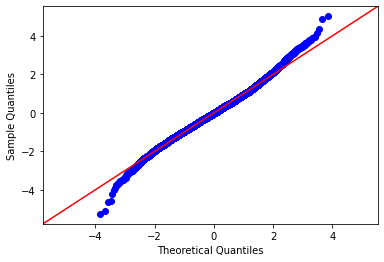

In [68]:
qqplot(model)

## Model #6: One Hot Encoding zipcodes

From the website 'gis-kingcounty.opendata.arcgis.com' I have loaded the ```all_zipcodes.csv``` file and extracted the zipcodes and cities in our data. In this step I will see how one hot encoding our zipcodes would affect our model and observe by how much it would alter our prices.

In [69]:
all_zipcodes = pd.read_csv('all_zipcodes.csv')
all_zipcodes.head()

,X,Y,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,PREFERRED_CITY,FEATURE_SOURCE
0,-122.584242,47.855762,1,98364,98364,35.0,PO Box,PORT GAMBLE,Placed Point
1,-122.202454,47.620601,2,98009,98009,33.0,PO Box,BELLEVUE,Placed Point
2,-122.186795,47.611861,3,98015,98015,33.0,PO Box,BELLEVUE,Placed Point
3,-121.972726,47.419935,4,98025,98025,33.0,PO Box,HOBART,Placed Point
4,-122.234416,47.380592,5,98035,98035,33.0,PO Box,KENT,Placed Point


In [70]:
zipcode_dict = {
    98178: 'Seattle',
    98125: 'Seattle',
    98028: 'Kenmore',
    98136: 'Seattle',
    98074: 'Sammamish',
    98053: 'Redmond',
    98003: 'Federal Way',
    98198: 'S Seattle',
    98146: 'S Seattle',
    98038: 'Maple Valley',
    98007: 'Bellevue',
    98115: 'Seattle',
    98107: 'Seattle',
    98126: 'Seattle',
    98019: 'Duvall',
    98103: 'Seattle',
    98002: 'Auburn',
    98133: 'Seattle',
    98040: 'Mercer',
    98092: 'Auburn',
    98030: 'Kent',
    98119: 'Seattle',
    98112: 'Seattle',
    98052: 'Redmond',
    98027: 'Issaquah',
    98117: 'Seattle',
    98058: 'Renton',
    98001: 'Auburn', 
    98056: 'Renton', 
    98166: 'S Seattle', 
    98023: 'Federal Way', 
    98070: 'Vashon', 
    98148: 'Seattle', 
    98105: 'Seattle', 
    98042: 'Kent', 
    98008: 'Bellevue',
    98059: 'Renton', 
    98122: 'Seattle', 
    98144: 'Seattle', 
    98004: 'Bellevue', 
    98005: 'Bellevue', 
    98034: 'Kirkland', 
    98075: 'Sammamish', 
    98116: 'Seattle', 
    98010: 'Black Diamond',
    98118: 'Seattle', 
    98199: 'Seattle', 
    98032: 'Kent', 
    98045: 'North Bend', 
    98102: 'Seattle', 
    98077: 'Woodinville', 
    98108: 'Seattle', 
    98168: 'S Seattle', 
    98177: 'N Seattle',
    98065: 'Snoqualmie', 
    98029: 'Issaquah', 
    98006: 'Bellevue', 
    98109: 'Seattle', 
    98022: 'Enumclaw', 
    98033: 'Kirkland', 
    98155: 'N Seattle', 
    98024: 'Fall City', 
    98011: 'Bothell',
    98031: 'Kent', 
    98106: 'Seattle', 
    98072: 'Woodinville', 
    98188: 'S Seattle', 
    98014: 'Carnation', 
    98055: 'Renton', 
    98039: 'Medina'
}

In [71]:
len(zipcode_dict)

70

Before moving on to the next step and creating dummies for all zipcodes, I will first group the zipcodes by city and there create dummies for those cities.

In [72]:
df_ohe2['City'] = df_ohe2.zipcode.map(lambda x: zipcode_dict[x])
print('Number of Cities:', df_ohe2.City.nunique())
df_ohe2.City.value_counts()

Number of Cities: 26


Seattle          6905
Renton           1587
Bellevue         1321
S Seattle        1205
Kent             1196
Redmond           971
Kirkland          956
Auburn            903
Sammamish         789
Federal Way       775
Issaquah          725
N Seattle         689
Maple Valley      586
Woodinville       467
Snoqualmie        305
Kenmore           281
Mercer            253
Enumclaw          230
North Bend        218
Bothell           194
Duvall            188
Carnation         119
Vashon            111
Black Diamond      99
Fall City          77
Medina             22
Name: City, dtype: int64

In [73]:
#create dummies for all cities.
ohe_City = pd.get_dummies(df_ohe2.City, prefix='C', drop_first=True)

City_cols = ohe_City.columns.to_list()

df_ohe3 = pd.concat([df_ohe2, ohe_City], axis=1)

In [74]:
City_cols

['C_Bellevue',
 'C_Black Diamond',
 'C_Bothell',
 'C_Carnation',
 'C_Duvall',
 'C_Enumclaw',
 'C_Fall City',
 'C_Federal Way',
 'C_Issaquah',
 'C_Kenmore',
 'C_Kent',
 'C_Kirkland',
 'C_Maple Valley',
 'C_Medina',
 'C_Mercer',
 'C_N Seattle',
 'C_North Bend',
 'C_Redmond',
 'C_Renton',
 'C_S Seattle',
 'C_Sammamish',
 'C_Seattle',
 'C_Snoqualmie',
 'C_Vashon',
 'C_Woodinville']

In [75]:
df_ohe3.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'month', 'year', 'waterfront', 'sqft_living_log', 'sqft_lot_log',
       'sqft_living15_log', 'sqft_lot15_log', 'Recent_Const', 'Floors',
       'Baths', 'Beds', 'Cond', 'Grade', 'Month', 'Gra_8', 'Gra_9',
       'Gra_abv_9', 'Gra_bel_7', 'Con_4', 'Con_abv_4', 'Con_bel_3', 'Bed_4',
       'Bed_5', 'Bed_abv_5', 'Bed_bel_3', 'Bat_abv_2.25', 'Bat_bel_2.25',
       'Flo_1.5', 'Flo_2 & 2.5', 'Flo_3.5', 'wat_1.0', 'Rec_True',
       'Mon_Spring', 'Mon_Summer', 'Mon_Winter', 'City', 'C_Bellevue',
       'C_Black Diamond', 'C_Bothell', 'C_Carnation', 'C_Duvall', 'C_Enumclaw',
       'C_Fall City', 'C_Federal Way', 'C_Issaquah', 'C_Kenmore', 'C_Kent',
       'C_Kirkland', 'C_Maple Valley', 'C_Medina', 'C_Mercer', 'C_N Seattle',
       'C_North Bend', 'C_Redmond'

In [76]:
logs

['sqft_living_log', 'sqft_lot_log']

In [77]:
ohe_cols

['Gra_8',
 'Gra_9',
 'Gra_abv_9',
 'Gra_bel_7',
 'Con_4',
 'Con_abv_4',
 'Con_bel_3',
 'Bed_4',
 'Bed_5',
 'Bed_abv_5',
 'Bed_bel_3',
 'Bat_abv_2.25',
 'Bat_bel_2.25',
 'Flo_1.5',
 'Flo_2 & 2.5',
 'Flo_3.5',
 'wat_1.0',
 'Rec_True',
 'Mon_Spring',
 'Mon_Summer',
 'Mon_Winter']

In [78]:
continuous

['lat', 'long']

Training Scores:
R2: 0.7990726924327654
Root Mean Squared Error: 131409.08703245595
Mean Absolute Error: 86077.47175513342
---
Testing Scores:
R2: 0.7960497475815979
Root Mean Squared Error: 130838.21927126184
Mean Absolute Error: 86037.8809633457


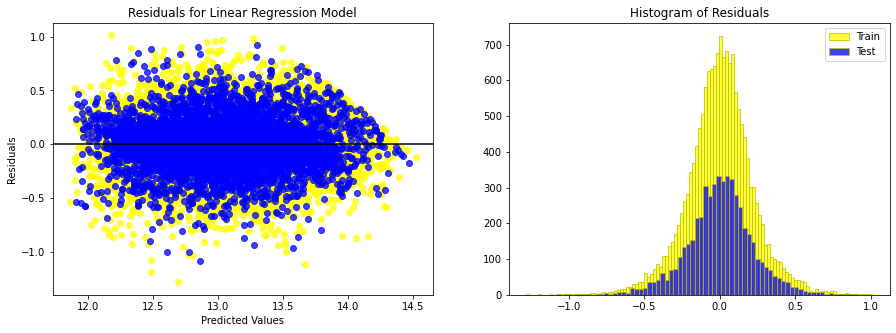

LinearRegression()

In [79]:
predictors = continuous + logs + ohe_cols + City_cols
sk_linear_regression(df_ohe3, predictors, outcome, log=True)

### Analysis

Ok, our best fit so far would have to be this model. There is a visible improvement in our R score and now our model can account for 79.5% of variance for our data. Noticable the RMSE has taken a big step forward signifying our data now would have an error of  around $133,300, not very accurate but definitely better. Let's take a look at the model summary below for some more details.

In [80]:
model = sm_linear_regression(df_ohe3, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     1259.
Date:                Sat, 12 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:57:32   Log-Likelihood:                 1423.8
No. Observations:               15879   AIC:                            -2746.
Df Residuals:                   15828   BIC:                            -2354.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -142.2288      5.393    -26.371      0.000    -152.801    -131.657
lat                 1.2126      0.038     31.632      0.000       1.137       1.288
long               -0.7622      0.043    -17.653      0.000      -0.847      -0.678
sqft_living_log     0.4819      0.009     56.415      0.000       0.465       0.499
sqft_lot_log        0.0523      0.003     18.053      0.000       0.047       0.058
Gra_8               0.1409      0.005     28.348      0.000       0.131       0.151
Gra_9               0.3041      0.007     41.177      0.000       0.290       0.319
Gra_abv_9           0.4405      0.010     44.348      0.000       0.421       0.460
Gra_bel_7          -0.1223      0.007    -18.088      0.000      -0.136      -0.109
Con_4               0.0614      0.004     13.815      0.000       0.053       0.070
Con_abv_4           0.1375      0.007     19.597      0.000       0.124       0.151
Con_bel_3          -0.1460      0.019     -7.636      0.000      -0.184      -0.109
Bed_4              -0.0201      0.005     -4.389      0.000      -0.029      -0.011
Bed_5              -0.0564      0.008     -7.176      0.000      -0.072      -0.041
Bed_abv_5          -0.0940      0.016     -5.972      0.000      -0.125      -0.063
Bed_bel_3           0.0528      0.006      8.523      0.000       0.041       0.065
Bat_abv_2.25        0.0508      0.006      8.366      0.000       0.039       0.063
Bat_bel_2.25       -0.0031      0.005     -0.573      0.567      -0.014       0.008
Flo_1.5             0.0812      0.007     12.187      0.000       0.068       0.094
Flo_2 & 2.5         0.0349      0.005      6.559      0.000       0.024       0.045
Flo_3.5            -0.0337      0.012     -2.734      0.006      -0.058      -0.010
wat_1.0             0.4901      0.026     18.575      0.000       0.438       0.542
Rec_True            0.0310      0.006      5.233      0.000       0.019       0.043
Mon_Spring          0.0511      0.005     10.520      0.000       0.042       0.061
Mon_Summer          0.0052      0.005      1.067      0.286      -0.004       0.015
Mon_Winter          0.0040      0.006      0.712      0.477      -0.007       0.015
C_Bellevue          0.4414      0.016     27.280      0.000       0.410       0.473
C_Black Diamond     0.3316      0.029     11.311      0.000       0.274       0.389
C_Bothell          -0.0812      0.027     -3.034      0.002      -0.134      -0.029
C_Carnation         0.1119      0.034      3.316      0.001       0.046       0.178
C_Duvall           -0.0143      0.029     -0.492      0.623      -0.071       0.043
C_Enumclaw          0.3605      0.021     17.152      0.000       0.319       0.402
C_Fall City         0.3826      0.035     10.793      0.000       0.313       0.452
C_Federal Way      -0.1096      0.014     -8.008      0.000

### One Hot Encoding Analysis and Plan of Action

Our R2 looks good for this model but the most concerning parts would be the p-values of some of the variables having more than 0.05. This could be caused by those variables actually having no influence on the price or it could also be a sign of multicollinearity. If we notice our confidence interval for those features, we see that it bounces between negative and positive values. This could mean that since the values of those intervals are close to zero then there is a higher chance that those features have no effect on the price or that it may have been caused purely by chance.

In this next step I will drop those features with high p-values and see how our model performs.



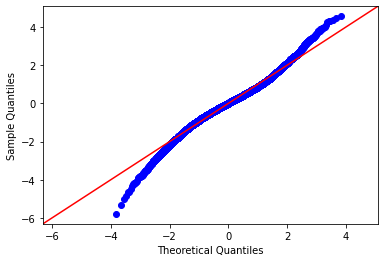

In [81]:
qqplot(model)

Removing 'Bat_bel_2.25', 'Bui_3.5', 'Mon_Summer', 'Mon_Winter' since they have a p-value of more than 0.05 and its coefficient doesn't seem to make sense being that it shows the price to decrease as the building Floors increase.

In [82]:
ohe_cols

['Gra_8',
 'Gra_9',
 'Gra_abv_9',
 'Gra_bel_7',
 'Con_4',
 'Con_abv_4',
 'Con_bel_3',
 'Bed_4',
 'Bed_5',
 'Bed_abv_5',
 'Bed_bel_3',
 'Bat_abv_2.25',
 'Bat_bel_2.25',
 'Flo_1.5',
 'Flo_2 & 2.5',
 'Flo_3.5',
 'wat_1.0',
 'Rec_True',
 'Mon_Spring',
 'Mon_Summer',
 'Mon_Winter']

In [83]:
#Removing 'Bat_bel_2.25', 'Flo_3.5', 'Mon_Summer', 'Mon_Winter' 
#since they have a p-value of more than 0.05
ohe_cols = ['Gra_8',
             'Gra_9',
             'Gra_abv_9',
             'Gra_bel_7',
             'Con_4',
             'Con_abv_4',
             'Con_bel_3',
             'Bed_4',
             'Bed_5',
             'Bed_abv_5',
             'Bed_bel_3',
             'Bat_abv_2.25',
             'Flo_1.5',
             'Flo_2 & 2.5',
             'wat_1.0',
             'Rec_True',
             'Mon_Spring',]

In [84]:
City_cols

['C_Bellevue',
 'C_Black Diamond',
 'C_Bothell',
 'C_Carnation',
 'C_Duvall',
 'C_Enumclaw',
 'C_Fall City',
 'C_Federal Way',
 'C_Issaquah',
 'C_Kenmore',
 'C_Kent',
 'C_Kirkland',
 'C_Maple Valley',
 'C_Medina',
 'C_Mercer',
 'C_N Seattle',
 'C_North Bend',
 'C_Redmond',
 'C_Renton',
 'C_S Seattle',
 'C_Sammamish',
 'C_Seattle',
 'C_Snoqualmie',
 'C_Vashon',
 'C_Woodinville']

In [85]:
#dropping cities with p-values higher than 0.05 (C_Woodinville, C_Kent, C_Vashon,C_Duvall )
City_cols = ['C_Bellevue',
             'C_Black Diamond',
             'C_Bothell',
             'C_Carnation',
             'C_Enumclaw',
             'C_Fall City',
             'C_Federal Way',
             'C_Issaquah',
             'C_Kenmore',
             'C_Kirkland',
             'C_Maple Valley',
             'C_Medina',
             'C_Mercer',
             'C_N Seattle',
             'C_North Bend',
             'C_Redmond',
             'C_Renton',
             'C_S Seattle',
             'C_Sammamish',
             'C_Seattle',
             'C_Snoqualmie']

Training Scores:
R2: 0.7989493265197796
Root Mean Squared Error: 131390.6276135667
Mean Absolute Error: 86096.23298654261
---
Testing Scores:
R2: 0.7958615441816992
Root Mean Squared Error: 130843.0733863609
Mean Absolute Error: 85981.79548462333


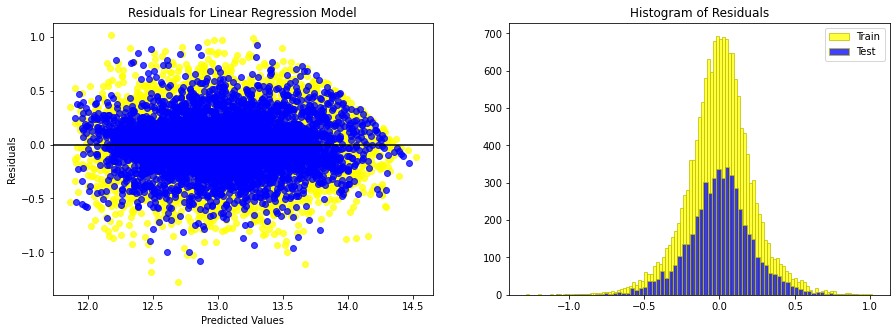

LinearRegression()

In [86]:
predictors = continuous + logs + ohe_cols + City_cols
sk_linear_regression(df_ohe3, predictors, outcome, log=True)

In [87]:
model = sm_linear_regression(df_ohe3, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     1498.
Date:                Sat, 12 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:57:33   Log-Likelihood:                 1418.9
No. Observations:               15879   AIC:                            -2752.
Df Residuals:                   15836   BIC:                            -2422.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -142.2071      4.698    -30.271      0.000    -151.415    -132.999
lat                 1.1958      0.023     50.929      0.000       1.150       1.242
long               -0.7684      0.035    -21.971      0.000      -0.837      -0.700
sqft_living_log     0.4829      0.008     57.532      0.000       0.466       0.499
sqft_lot_log        0.0538      0.003     19.552      0.000       0.048       0.059
Gra_8               0.1389      0.005     28.577      0.000       0.129       0.148
Gra_9               0.3020      0.007     41.550      0.000       0.288       0.316
Gra_abv_9           0.4369      0.010     44.689      0.000       0.418       0.456
Gra_bel_7          -0.1221      0.007    -18.094      0.000      -0.135      -0.109
Con_4               0.0623      0.004     14.104      0.000       0.054       0.071
Con_abv_4           0.1388      0.007     19.839      0.000       0.125       0.153
Con_bel_3          -0.1462      0.019     -7.649      0.000      -0.184      -0.109
Bed_4              -0.0194      0.005     -4.242      0.000      -0.028      -0.010
Bed_5              -0.0554      0.008     -7.063      0.000      -0.071      -0.040
Bed_abv_5          -0.0934      0.016     -5.932      0.000      -0.124      -0.063
Bed_bel_3           0.0537      0.006      8.690      0.000       0.042       0.066
Bat_abv_2.25        0.0516      0.006      9.109      0.000       0.040       0.063
Flo_1.5             0.0832      0.007     12.603      0.000       0.070       0.096
Flo_2 & 2.5         0.0399      0.005      8.272      0.000       0.030       0.049
wat_1.0             0.4884      0.026     18.623      0.000       0.437       0.540
Rec_True            0.0281      0.006      4.829      0.000       0.017       0.039
Mon_Spring          0.0481      0.004     12.554      0.000       0.041       0.056
C_Bellevue          0.4427      0.009     47.003      0.000       0.424       0.461
C_Black Diamond     0.3273      0.028     11.809      0.000       0.273       0.382
C_Bothell          -0.0775      0.021     -3.746      0.000      -0.118      -0.037
C_Carnation         0.1135      0.027      4.242      0.000       0.061       0.166
C_Enumclaw          0.3546      0.020     18.177      0.000       0.316       0.393
C_Fall City         0.3813      0.031     12.155      0.000       0.320       0.443
C_Federal Way      -0.1139      0.012     -9.443      0.000      -0.138      -0.090
C_Issaquah          0.3902      0.012     33.199      0.000       0.367       0.413
C_Kenmore          -0.1467      0.018     -7.962      0.000      -0.183      -0.111
C_Kirkland          0.1829      0.012     15.707      0.000       0.160       0.206
C_Maple Valley      0.2283      0.013     17.832      0.000       0.203       0.253
C_Medina            0.8777      0.056     15.697      0.000

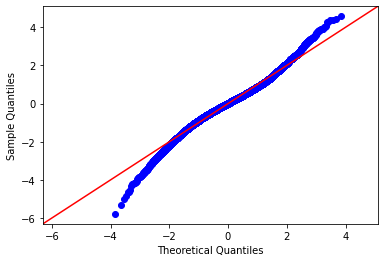

In [88]:
qqplot(model)

Finally our model now looks like a good fit. We can now account for 79.9% of our data's variance.  Our data would have an error of around $133,000 which is a similar to our previous model.

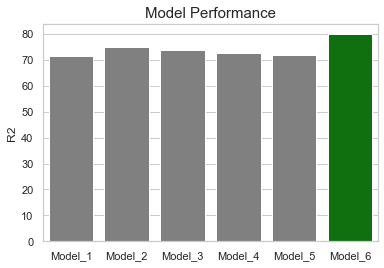

In [89]:
#Looking at the results of RMSE for all our models
values = [71.4, 74.8, 73.8, 72.8, 71.8, 79.9]
keys   = ['Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5', 'Model_6']
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
clrs    = ['green' if (x == max(values)) else 'grey' for x in values]
sns.barplot(keys, values, palette = clrs)
ax.set_ylabel('R2')
ax.set_xticklabels(['Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5', 'Model_6'])
ax.set_title('Model Performance', fontsize=15);

# Conclusion

## Conclusion and Recomendation

As we have seen, in our final model, we could account for about 79.5% of the variance in the housing price data. Our mean absolute error for the model is around $133,000, which is not ideal for accurately predicting a sale price. That said, based on this model, we know that the five most influential factors in property sale price with their coefficients are:


- **Built in Medina**: (0.86)
- **Built in Mercer**:(0.58) 
    A property in Medina would be worth (0.86-0.58) 27% more than a property in Mercer.
    
- **Square Footage of Living**: 
    a 1% increase would account for 0.49% increase in price
    
- **Waterfront View**: (0.49) 
    A property's price with waterfront would be 49%  higher than if it didn't have waterfront. 
    
- **Condition 4**:(0.059)
- **Condition abv_4**:(0.135)
    Sale price would be 7.6% higher for a property with Condition (>4) than for a condition value(4) property.


1. Adding square footage to a property can add significant value to a house.
2. Direct buyers with higher budget and priority of living area to invest on properties towards the Northern region of Seattle. 
3. Engage only in transaction of  homes with Condition value of (4-5).


The model can be used to predict house price although the model is not amazingly accurate. Still the results can be used for understanding the features of a property's relationship to the market. The models here focus on isolating factors for accurate coefficients rather than on precise prediction. 

# Areas of Further Study

This model has a lot of room for improvement. Other areas to explore in this data for the Real Estate agency are:

- Discover how sqft_basement for a given Lot area would play a role  
  in the sales price. 
- Determine the value of different types of expansions (Bedroom, Bathroom) and 
  investigate how that affects the value of a house.
- Identify areas of Seattle where housing prices are increasing and possibly predict which neighborhoods will be ideal for       settlement  in the future.  
- Improve the model with more data over the years after 2015 and observe if there is any change in the trend of the major   factors.